# Dubins Path Samples

This notebook demonstrates how to use the Dubins trajectory planner from `planner_dubins.py` to generate sample paths with various configurations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cyecca.planning.dubins import derive_dubins, DubinsPathType

## Set up the Dubins planner

Initialize the planning and evaluation functions.

In [2]:
# Derive the Dubins planning functions
plan_fn, eval_fn = derive_dubins()

print("Dubins planning functions loaded successfully")

Dubins planning functions loaded successfully


## Define helper functions

Create utility functions to plan and evaluate Dubins paths.

In [3]:
# Moved
def plan_dubins_path(start_pos, start_yaw, end_pos, end_yaw, turn_radius):
    """
    Plan a Dubins path between two poses.
    
    Args:
        start_pos: [x, y] starting position
        start_yaw: starting heading (radians)
        end_pos: [x, y] ending position
        end_yaw: ending heading (radians)
        turn_radius: minimum turning radius
    
    Returns:
        Dictionary with path information
    """
    p0 = np.array([start_pos[0], start_pos[1]])
    p1 = np.array([end_pos[0], end_pos[1]])
    
    cost, ptype, a1, d, a2, tp0, tp1, c0, c1 = plan_fn(
        p0, start_yaw, p1, end_yaw, turn_radius
    )
    
    return {
        'cost': float(cost),
        'type': DubinsPathType.name(ptype),
        'a1': a1,
        'd': d,
        'a2': a2,
        'tp0': np.array(tp0).flatten(),
        'tp1': np.array(tp1).flatten(),
        'c0': np.array(c0).flatten(),
        'c1': np.array(c1).flatten()
    }

# moved
def evaluate_dubins_path(plan_info, start_pos, start_yaw, end_pos, end_yaw, 
                        turn_radius, num_points=1000):
    """
    Evaluate a planned Dubins path to generate sample points.
    
    Args:
        plan_info: Dictionary returned from plan_dubins_path
        start_pos: [x, y] starting position
        start_yaw: starting heading (radians)
        end_pos: [x, y] ending position
        end_yaw: ending heading (radians)
        turn_radius: minimum turning radius
        num_points: number of points to sample along path
    
    Returns:
        Arrays of (x, y, psi) points along the path
    """
    p0 = np.array([start_pos[0], start_pos[1]])
    p1 = np.array([end_pos[0], end_pos[1]])
    
    points = []
    for s in np.linspace(0, 1, num_points):
        x, y, psi = eval_fn(
            s,
            p0,
            start_yaw,
            plan_info['a1'],
            plan_info['d'],
            plan_info['a2'],
            plan_info['tp0'],
            plan_info['tp1'],
            plan_info['c0'],
            plan_info['c1'],
            turn_radius
        )
        points.append([float(x), float(y), float(psi)])
    
    return np.array(points)

def compute_curvature(path_points):
    """
    Compute curvature along a path using the yaw angle (heading).
    
    Curvature is computed as κ = dψ/ds, where:
    - dψ is the change in heading angle (radians)
    - ds is the arc length traveled (meters)
    
    Args:
        path_points: Nx3 array of [x, y, psi] points
    
    Returns:
        Array of curvature values at each point
    """
    n = len(path_points)
    curvature = np.zeros(n)

    print(path_points)
    
    # Compute arc length between consecutive points
    arc_lengths = np.zeros(n)
    for i in range(1, n):
        ds = np.linalg.norm(path_points[i, :2] - path_points[i-1, :2])
        arc_lengths[i] = arc_lengths[i-1] + ds
    
    # Use finite differences to compute curvature from heading angle
    for i in range(n):
        if i == 0:
            # Forward difference at start: use points 0 and 1
            dpsi = path_points[i+1, 2] - path_points[i, 2]
            ds = arc_lengths[i+1] - arc_lengths[i]
        elif i == n - 1:
            # Backward difference at end: use points n-2 and n-1
            dpsi = path_points[i, 2] - path_points[i-1, 2]
            ds = arc_lengths[i] - arc_lengths[i-1]
        else:
            # Central difference in between: use points i-1, i, i+1
            # dpsi = change in angle over a distance of 2*ds_avg
            dpsi = path_points[i+1, 2] - path_points[i-1, 2]
            ds = arc_lengths[i+1] - arc_lengths[i-1]
        
        # Handle angle wraparound (keep dpsi in [-π, π])
        while dpsi > np.pi:
            dpsi -= 2*np.pi
        while dpsi < -np.pi:
            dpsi += 2*np.pi
        
        # Curvature = change in heading / arc length
        if ds > 1e-12:
            curvature[i] = dpsi / ds
        else:
            curvature[i] = 0.0
    
    return curvature

# Moved
def compute_curvature_from_xy(path_xy):
    """
    Compute SIGNED curvature from x,y positions using the geometric curvature formula.
    Sign is determined by the orientation (left turn positive, right turn negative).
    """

    # Handle both Nx2 and Nx3 inputs
    if path_xy.shape[1] >= 3:
        xy = path_xy[:, :2]
    else:
        xy = path_xy

    n = len(xy)
    curvature = np.zeros(n)

    for i in range(n):
        if i == 0 or i == n - 1:
            if i == 0 and n > 2:
                p0, p1, p2 = xy[0], xy[1], xy[2]
            elif i == n - 1 and n > 2:
                p0, p1, p2 = xy[n-3], xy[n-2], xy[n-1]
            else:
                curvature[i] = 0.0
                continue
        else:
            p0, p1, p2 = xy[i-1], xy[i], xy[i+1]

        # Side lengths
        a = np.linalg.norm(p1 - p2)
        b = np.linalg.norm(p0 - p2)
        c = np.linalg.norm(p0 - p1)

        # 2D cross product gives twice signed area:
        cross = (p1[0] - p0[0]) * (p2[1] - p0[1]) - (p1[1] - p0[1]) * (p2[0] - p0[0])
        area = 0.5 * abs(cross)

        # unsigned curvature
        denom = a * b * c
        if denom > 1e-12:
            kappa = 4.0 * area / denom
        else:
            kappa = 0.0

        # apply sign
        sign = np.sign(cross)  # positive = CCW turn
        curvature[i] = sign * kappa

    return curvature



def plot_curvature(path_points, curvature, title=''):
    """
    Plot the path and curvature distribution.
    
    Args:
        path_points: Nx3 array of [x, y, psi] points
        curvature: Array of curvature values
        title: Title for the plot
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot path
    ax1.plot(path_points[:, 0], path_points[:, 1], 'b-', linewidth=2)
    ax1.plot(path_points[0, 0], path_points[0, 1], 'go', markersize=10, label='Start')
    ax1.plot(path_points[-1, 0], path_points[-1, 1], 'r*', markersize=20, label='End')
    ax1.set_xlabel('X (m)', fontsize=12)
    ax1.set_ylabel('Y (m)', fontsize=12)
    ax1.set_title('Path', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    ax1.legend()
    
    # Plot curvature
    arc_length = np.zeros(len(curvature))
    for i in range(1, len(curvature)):
        arc_length[i] = arc_length[i-1] + np.linalg.norm(path_points[i, :2] - path_points[i-1, :2])
    
    ax2.plot(arc_length/arc_length[-1], curvature, 'b-', linewidth=2)
    ax2.fill_between(arc_length/arc_length[-1], curvature, alpha=0.3)
    ax2.set_xlabel('Arc Length (m)', fontsize=12)
    ax2.set_ylabel('Curvature (1/m)', fontsize=12)
    ax2.set_title('Curvature Distribution', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    if title:
        fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    return fig, (ax1, ax2)


def plot_dubins_path(ax, path_points, plan_info, start_pos, end_pos, 
                    turn_radius, label=''):
    """
    Plot a Dubins path on a matplotlib axis.
    """
    x = path_points[:, 0]
    y = path_points[:, 1]
    
    # Plot the path
    ax.plot(x, y, 'b-', linewidth=2, label=f'Path {label}' if label else 'Path')
    
    # Plot start and end points
    ax.plot(start_pos[0], start_pos[1], 'go', markersize=10, label='Start')
    ax.plot(end_pos[0], end_pos[1], 'r*', markersize=20, label='End')
    
    # Plot turn circles
    circle1 = plt.Circle(plan_info['c0'], turn_radius, fill=False, 
                         linestyle='--', color='gray', alpha=0.5)
    circle2 = plt.Circle(plan_info['c1'], turn_radius, fill=False, 
                         linestyle='--', color='gray', alpha=0.5)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    
    # Plot circle centers
    ax.plot(plan_info['c0'][0], plan_info['c0'][1], 'k+', markersize=8)
    ax.plot(plan_info['c1'][0], plan_info['c1'][1], 'k+', markersize=8)


print("Helper functions defined")

Helper functions defined


## Sample 4: 180-Degree Turnaround

A path where the vehicle needs to turn around and head in the opposite direction.

In [4]:
# Sample 4: 180-degree turnaround
start_pos_4 = [0, 0]
start_yaw_4 = 0
end_pos_4 = [-5, 25]
end_yaw_4 = 5*np.pi/4  # 180 degrees (pointing back)
turn_radius_4 = 8.0

plan_4 = plan_dubins_path(start_pos_4, start_yaw_4, end_pos_4, end_yaw_4, turn_radius_4)
points_4 = evaluate_dubins_path(plan_4, start_pos_4, start_yaw_4, end_pos_4, end_yaw_4, turn_radius_4)

print(f"Sample 4 - 180° Turnaround")
print(f"  Path type: {plan_4['type']}")
print(f"  Cost: {plan_4['cost']:.4f}")
print(f"  Turn radius: {turn_radius_4}")
print(f"  Path length: {plan_4['cost'] * turn_radius_4:.4f}")

Sample 4 - 180° Turnaround
  Path type: LSL
  Cost: 42.7781
  Turn radius: 8.0
  Path length: 342.2246


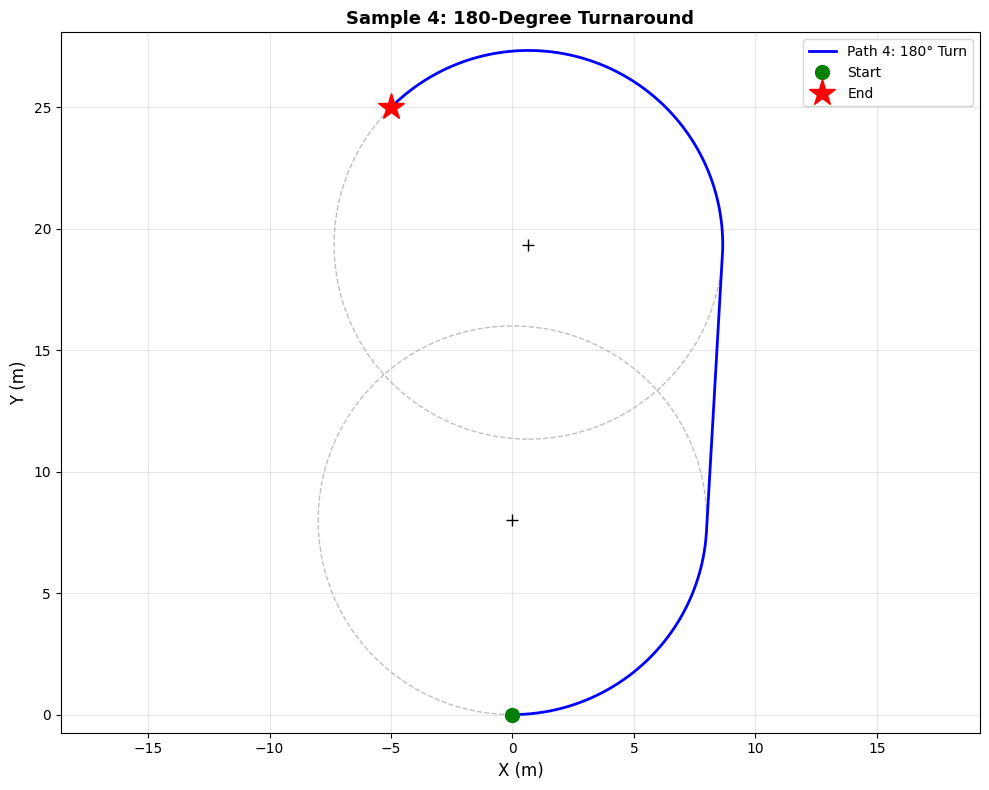

In [5]:
# Plot Sample 4
fig, ax = plt.subplots(figsize=(10, 8))

plot_dubins_path(ax, points_4, plan_4, start_pos_4, end_pos_4, turn_radius_4, '4: 180° Turn')

ax.set_xlabel('X (m)', fontsize=12)
ax.set_ylabel('Y (m)', fontsize=12)
ax.set_title('Sample 4: 180-Degree Turnaround', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axis('equal')
ax.legend(loc='best')

plt.tight_layout()
plt.show()

In [6]:
curvature_4 = compute_curvature(points_4)

print("\nSample 4 - 180° Turnaround")
print(f"  Max curvature: {np.max(np.abs(curvature_4)):.6f} 1/m")
print(f"  Mean curvature: {np.mean(np.abs(curvature_4)):.6f} 1/m")
print(f"  Min turning radius: {1/np.max(np.abs(curvature_4)):.4f} m" if np.max(np.abs(curvature_4)) > 1e-6 else "  Straight line")

[[ 4.89858720e-16  0.00000000e+00  0.00000000e+00]
 [ 4.28206912e-02  1.14601546e-04  5.35261196e-03]
 [ 8.56401556e-02  4.58402899e-04  1.07052239e-02]
 ...
 [-4.93911913e+00  2.50602326e+01  3.91628559e+00]
 [-4.96964016e+00  2.50301978e+01  3.92163821e+00]
 [-5.00000000e+00  2.50000000e+01  3.92699082e+00]]

Sample 4 - 180° Turnaround
  Max curvature: 0.125000 1/m
  Mean curvature: 0.091832 1/m
  Min turning radius: 8.0000 m


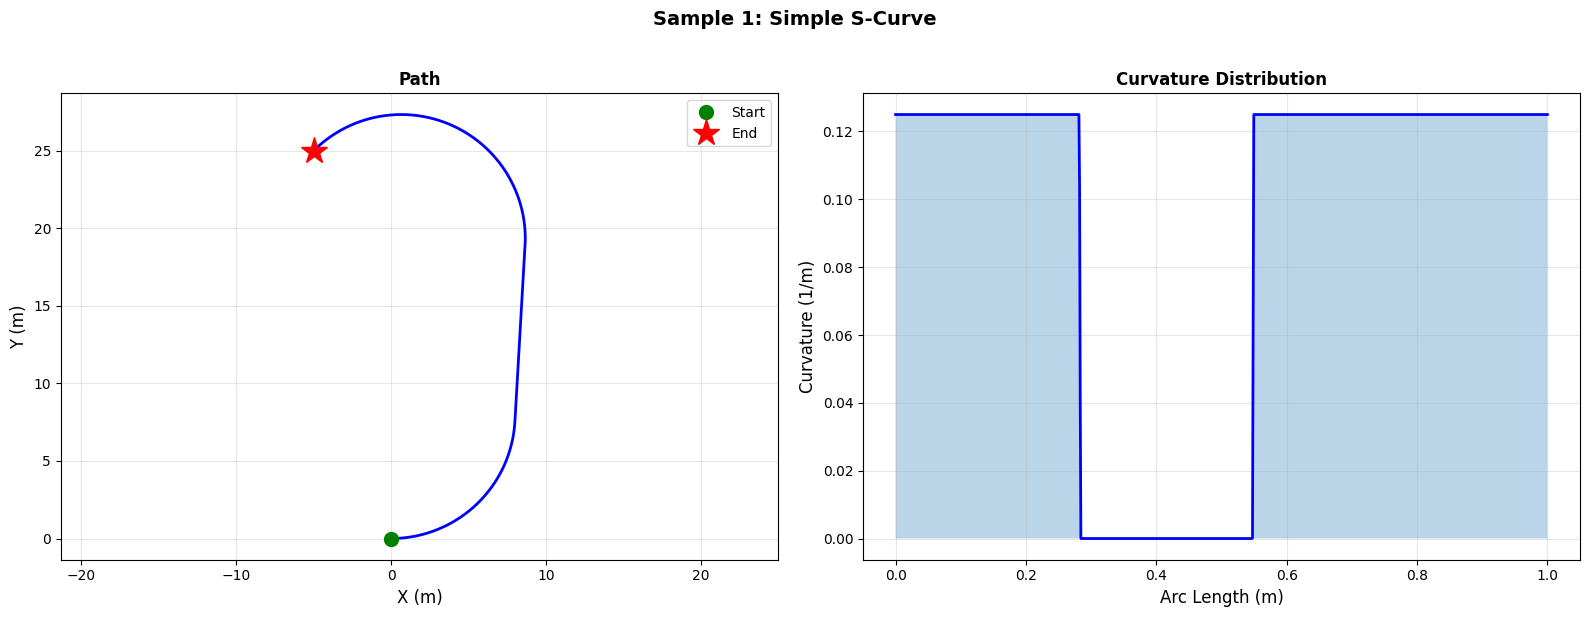

In [7]:
# Plot curvature for Sample 1
plot_curvature(points_4, curvature_4, 'Sample 1: Simple S-Curve')
plt.show()

In [8]:
# from polynomial_optimization import run_poly_optimization, plot_piecewise_polynomials, plot_derivatives

# boundary_positions = [[0, None, None, 0]]      # Position: start=0, end=0
# boundary_velocities = [[None, None, None, None]]       # Velocity: start=0, others free
# boundary_accelerations = [[0.125, None, None, 0.125]]    # Acceleration: start=0
# boundary_jerk = [[0, None, None, 0]]             # Jerk: start=0
# boundary_snap = [[0, None, None, 0]]             # Snap: start=0
# boundary_crackle = [[None, None, None, None]]             # Snap: start=0
# boundary_pop = [[None, None, None, None]]             # Snap: start=0
# boundary_lock = [[None, None, None, None]]             # Snap: start=0

# boundary_conditions = [
#     boundary_positions,
#     boundary_velocities,
#     boundary_accelerations,
#     boundary_jerk,
#     boundary_snap,
#     boundary_crackle,
#     boundary_pop,
#     boundary_lock
# ]

# # Define acceleration discontinuities (jumps in 2nd derivative)
# continuity_changes = [[2, -0.125], [7, 0.125]]
# tau = [0.3, 0.55-0.3, 1.0-0.55]  # Segment durations

# # Solve optimization problem
# outputs = run_poly_optimization(
#     order=7,
#     tau=tau,
#     segments=3,
#     weights=[0, 0, 0, 0, 100.0, 0, 0, 0],  # Minimize snap (4th derivative)
#     boundary_conditions=boundary_conditions,
#     continuity=continuity_changes
# )

# # Plot results

# fig1, ax1 = plot_piecewise_polynomials(
#     outputs['polys'],
#     tau,
#     title="Optimized Piecewise Polynomial Trajectory"
# )
# plt.tight_layout()
# plt.show()

# fig2, axes2 = plot_derivatives(
#     outputs['polys'],
#     tau,
#     title="Trajectory Derivatives: Position, Velocity, Acceleration, Jerk"
# )
# plt.show()

## Extract Dubins Path Segments with Arc Lengths

Extract the three Dubins segments (arc, straight, arc) and compute their arc lengths for use in polynomial trajectory optimization.

In [9]:
def extract_dubins_segments(plan_info, turn_radius):
    """
    Extract the three segments of a Dubins path and compute their arc lengths.
    
    A Dubins path consists of: Arc1 -> Straight -> Arc2
    This function computes the length and normalized time for each segment.
    
    Args:
        plan_info: Dictionary from plan_dubins_path() with keys: a0, a1, a2, c0, c1
                   a0, a1, a2: Angles (in radians) for turn1, straight, turn2
                   c0, c1: Centers of the two circular arcs
        turn_radius: Vehicle turning radius (meters)
    
    Returns:
        dict: {
            'segment_1_arc': Arc length of first turn (meters)
            'segment_2_straight': Arc length of straight segment (meters)
            'segment_3_arc': Arc length of second turn (meters)
            'total_length': Total path length (meters)
            'segment_times_normalized': [τ₁, τ₂, τ₃] normalized so τ₁+τ₂+τ₃=1
        }
    """
    # Extract angles from plan
    a1 = float(plan_info['a1'])  # First arc angle
    a2 = float(plan_info['a2'])  # Second arc angle
    
    # Segment 1: First circular arc
    segment_1_arc = abs(a1) * turn_radius
    
    # Segment 3: Second circular arc
    segment_3_arc = abs(a2) * turn_radius
    
    # Segment 2: Straight line segment
    # Use the straight segment length from plan_info if available, else compute from geometry
    if 'd' in plan_info:
        segment_2_straight = float(plan_info['d'])
    else:
        # Compute distance between arc endpoints
        c0 = np.array(plan_info['c0'])
        c1 = np.array(plan_info['c1'])
        segment_2_straight = np.linalg.norm(c1 - c0)
    
    # Total length
    total_length = segment_1_arc + segment_2_straight + segment_3_arc
    
    # Normalized segment times (for polynomial trajectory optimization)
    segment_times_normalized = [
        segment_1_arc / total_length,
        segment_2_straight / total_length,
        segment_3_arc / total_length
    ]
    
    return {
        'segment_1_arc': segment_1_arc,
        'segment_2_straight': segment_2_straight,
        'segment_3_arc': segment_3_arc,
        'total_length': total_length,
        'segment_times_normalized': segment_times_normalized
    }


# Extract segments from sample 4
segments_4 = extract_dubins_segments(plan_4, turn_radius_4)
print("Dubins Path Segments (Sample 4: 180° Turnaround)")
print(f"  Segment 1 (initial arc):  {segments_4['segment_1_arc']:.4f} m  ({np.degrees(float(plan_4['a1'])):.2f}°)")
print(f"  Segment 2 (straight):     {segments_4['segment_2_straight']:.4f} m")
print(f"  Segment 3 (final arc):    {segments_4['segment_3_arc']:.4f} m  ({np.degrees(float(plan_4['a2'])):.2f}°)")
print(f"  Total path length:        {segments_4['total_length']:.4f} m")

Dubins Path Segments (Sample 4: 180° Turnaround)
  Segment 1 (initial arc):  12.1036 m  (86.69°)
  Segment 2 (straight):     11.3621 m
  Segment 3 (final arc):    19.3123 m  (138.31°)
  Total path length:        42.7781 m


Total path length for plotting: 42.7781 m
42.77803729417928


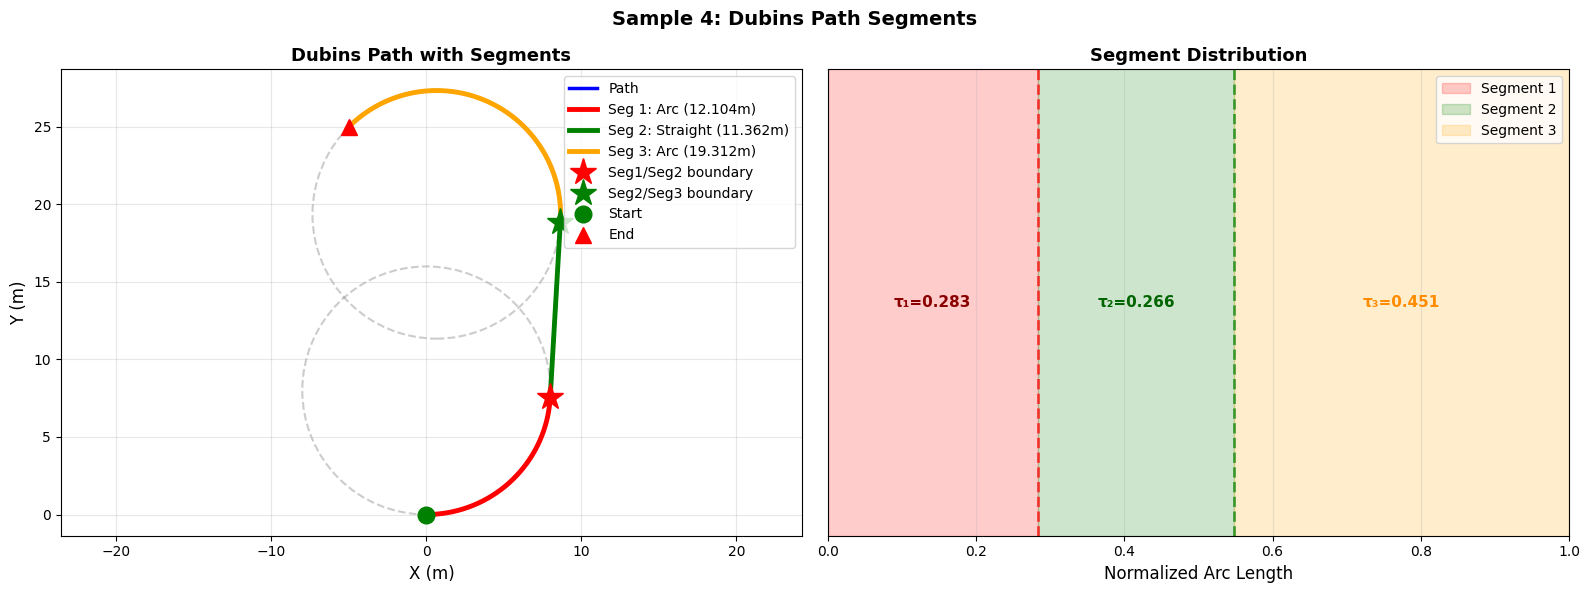

In [10]:
def plot_dubins_segments(path_points, plan_info, turn_radius, start_pos, end_pos, title=''):
    """
    Visualize the Dubins path with the three segments marked.
    
    Args:
        path_points: Nx3 array of [x, y, psi] points along the path
        plan_info: Dictionary from plan_dubins_path
        turn_radius: Vehicle turning radius
        start_pos: Starting position [x, y]
        end_pos: Ending position [x, y]
        title: Title for the plot
    """
    segments = extract_dubins_segments(plan_info, turn_radius)
    total_length = segments['total_length']
    print(f"Total path length for plotting: {total_length:.4f} m")
    
    # Compute cumulative arc lengths along the path
    arc_lengths = np.zeros(len(path_points))
    for i in range(1, len(path_points)):
        arc_lengths[i] = arc_lengths[i-1] + np.linalg.norm(path_points[i, :2] - path_points[i-1, :2])
    
    # Normalize arc lengths
    normalized_arc = arc_lengths / arc_lengths[-1]

    print(arc_lengths[-1])
    
    # Find indices where segments transition
    seg1_end = segments['segment_times_normalized'][0]
    seg2_end = seg1_end + segments['segment_times_normalized'][1]
    
    # Find closest points to segment transitions
    idx1 = np.argmin(np.abs(normalized_arc - seg1_end))
    idx2 = np.argmin(np.abs(normalized_arc - seg2_end))
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Path with segment boundaries
    ax1.plot(path_points[:, 0], path_points[:, 1], 'b-', linewidth=2.5, label='Path')
    
    # Color segments
    ax1.plot(path_points[:idx1+1, 0], path_points[:idx1+1, 1], 'r-', linewidth=3.5, 
             label=f'Seg 1: Arc ({segments["segment_1_arc"]:.3f}m)')
    ax1.plot(path_points[idx1:idx2+1, 0], path_points[idx1:idx2+1, 1], 'g-', linewidth=3.5, 
             label=f'Seg 2: Straight ({segments["segment_2_straight"]:.3f}m)')
    ax1.plot(path_points[idx2:, 0], path_points[idx2:, 1], 'orange', linewidth=3.5, 
             label=f'Seg 3: Arc ({segments["segment_3_arc"]:.3f}m)')
    
    # Mark segment boundaries
    ax1.plot(path_points[idx1, 0], path_points[idx1, 1], 'r*', markersize=20, label='Seg1/Seg2 boundary')
    ax1.plot(path_points[idx2, 0], path_points[idx2, 1], 'g*', markersize=20, label='Seg2/Seg3 boundary')
    
    # Mark start and end
    ax1.plot(start_pos[0], start_pos[1], 'go', markersize=12, label='Start', zorder=5)
    ax1.plot(end_pos[0], end_pos[1], 'r^', markersize=12, label='End', zorder=5)
    
    # Plot turn circles
    circle1 = plt.Circle(plan_info['c0'], turn_radius, fill=False, linestyle='--', 
                        color='gray', alpha=0.4, linewidth=1.5)
    circle2 = plt.Circle(plan_info['c1'], turn_radius, fill=False, linestyle='--', 
                        color='gray', alpha=0.4, linewidth=1.5)
    ax1.add_patch(circle1)
    ax1.add_patch(circle2)
    
    ax1.set_xlabel('X (m)', fontsize=12)
    ax1.set_ylabel('Y (m)', fontsize=12)
    ax1.set_title('Dubins Path with Segments', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    ax1.legend(loc='best', fontsize=10)
    
    # Plot 2: Arc length progression with segment boundaries
    colors = ['red', 'green', 'orange']
    labels = ['Segment 1 (Arc)', 'Segment 2 (Straight)', 'Segment 3 (Arc)']
    
    ax2.fill_between([0, seg1_end], 0, 1, alpha=0.2, color='red', label='Segment 1')
    ax2.fill_between([seg1_end, seg2_end], 0, 1, alpha=0.2, color='green', label='Segment 2')
    ax2.fill_between([seg2_end, 1], 0, 1, alpha=0.2, color='orange', label='Segment 3')
    
    ax2.axvline(seg1_end, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax2.axvline(seg2_end, color='green', linestyle='--', linewidth=2, alpha=0.7)
    
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.set_xlabel('Normalized Arc Length', fontsize=12)
    ax2.set_ylabel('', fontsize=12)
    ax2.set_yticks([])
    ax2.set_title('Segment Distribution', fontsize=13, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Add text annotations
    ax2.text(seg1_end/2, 0.5, f'τ₁={seg1_end:.3f}', ha='center', va='center', 
            fontsize=11, fontweight='bold', color='darkred')
    ax2.text((seg1_end+seg2_end)/2, 0.5, f'τ₂={segments["segment_times_normalized"][1]:.3f}', 
            ha='center', va='center', fontsize=11, fontweight='bold', color='darkgreen')
    ax2.text((seg2_end+1)/2, 0.5, f'τ₃={segments["segment_times_normalized"][2]:.3f}', 
            ha='center', va='center', fontsize=11, fontweight='bold', color='darkorange')
    
    if title:
        fig.suptitle(title, fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    return fig, (ax1, ax2)


# Plot the segments
fig_segs, axes_segs = plot_dubins_segments(points_4, plan_4, turn_radius_4, start_pos_4, end_pos_4,
                                           title='Sample 4: Dubins Path Segments')
plt.show()


## Use Dubins Segments for Polynomial Trajectory Optimization

Use the three clear segment arc lengths from the Dubins path as the time intervals for polynomial trajectory optimization.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      108

Total number of variables............................:       24
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       16
Total number of inequality c

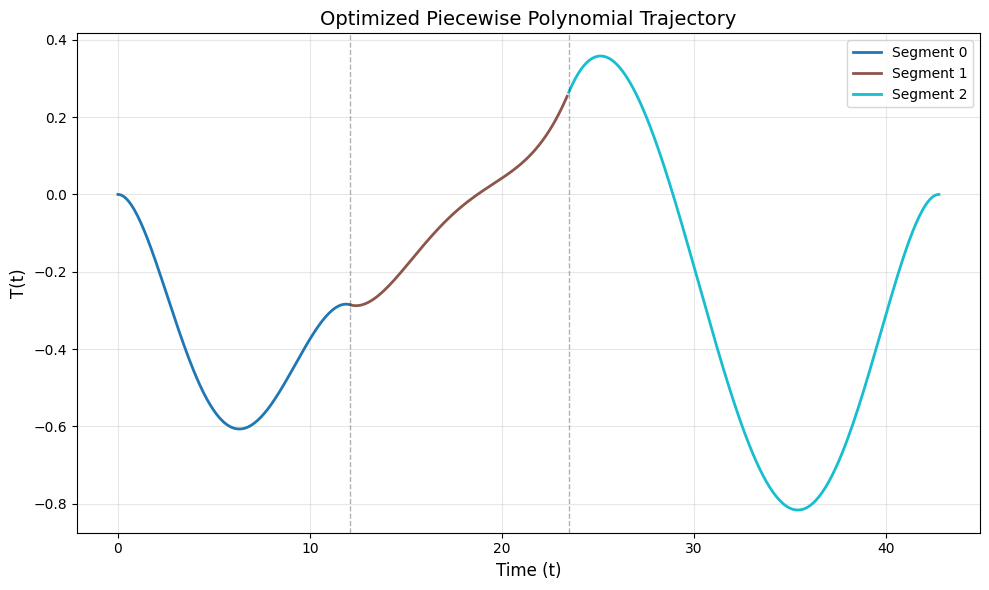

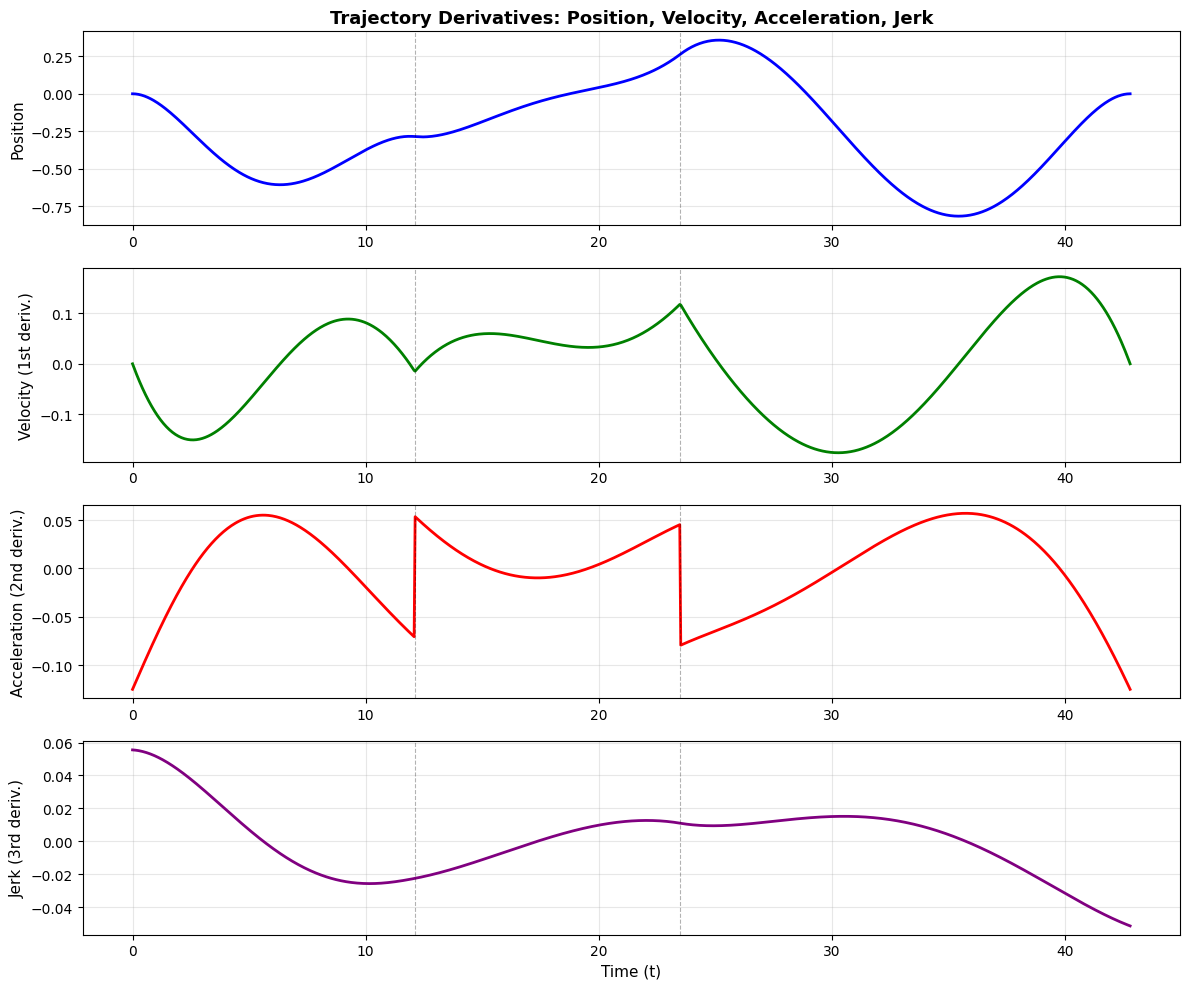

[12.1062023, 11.378974600000001, 19.292923100000003]


In [11]:
from polynomial_optimization import run_poly_optimization, plot_piecewise_polynomials, plot_derivatives
R = 8.0#/(42.7781*7.5)  # Turning radius
boundary_positions = [[0, None, None, 0]]      # Position: start=0, end=
boundary_velocities = [[0, None, None, 0]]       # Velocity: start=0, others free
boundary_accelerations = [[-1/R, None, None, -1/R]]    # Acceleration: start=0
boundary_jerk = [[None, None, None, None]]             # Jerk: start=0
boundary_snap = [[None, None, None, None]]             # Snap: start=0
boundary_crackle = [[None, None, None, None]]             # Snap: start=0
boundary_pop = [[None, None, None, None]]             # Snap: start=0
boundary_lock = [[None, None, None, None]]             # Snap: start=0

boundary_conditions = [
    boundary_positions,
    boundary_velocities,
    boundary_accelerations,
    boundary_jerk,
    boundary_snap,
    boundary_crackle,
    boundary_pop,
    boundary_lock
]

# Define acceleration discontinuities (jumps in 2nd derivative)
continuity_changes = [[2, 1/R], [7, -1/R]]
tau = [0.283*42.7781, 0.266*42.7781, 0.451*42.7781]  # Segment durations

# Solve optimization problem
outputs = run_poly_optimization(
    order=7,
    tau=tau,
    segments=3,
    weights=[0.1, 0.1, 0.1, 0.1, 1000, 0.1, 0.1, 0.1],  # Minimize snap (4th derivative)
    boundary_conditions=boundary_conditions,
    continuity=continuity_changes
)

# Plot results

fig1, ax1 = plot_piecewise_polynomials(
    outputs['polys'],
    tau,
    title="Optimized Piecewise Polynomial Trajectory"
)
plt.tight_layout()
plt.show()

fig2, axes2 = plot_derivatives(
    outputs['polys'],
    tau,
    title="Trajectory Derivatives: Position, Velocity, Acceleration, Jerk"
)
plt.show()
print(tau)

# Normalize polynomials so input variable ranges from 0 to 1 instead of 0 to tau_i
# For a polynomial P(t) where t in [0, tau], we want Q(s) where s in [0, 1]
# Substitute t = s * tau to get Q(s) = P(s * tau)




[ 0.          0.04282084  0.08564169  0.12846253  0.17128338  0.21410422
  0.25692507  0.29974591  0.34256676  0.3853876   0.42820845  0.47102929
  0.51385013  0.55667098  0.59949182  0.64231267  0.68513351  0.72795436
  0.7707752   0.81359605  0.85641689  0.89923774  0.94205858  0.98487943
  1.02770027  1.07052111  1.11334196  1.1561628   1.19898365  1.24180449
  1.28462534  1.32744618  1.37026703  1.41308787  1.45590872  1.49872956
  1.5415504   1.58437125  1.62719209  1.67001294  1.71283378  1.75565463
  1.79847547  1.84129632  1.88411716  1.92693801  1.96975885  2.01257969
  2.05540054  2.09822138  2.14104223  2.18386307  2.22668392  2.26950476
  2.31232561  2.35514645  2.3979673   2.44078814  2.48360899  2.52642983
  2.56925067  2.61207152  2.65489236  2.69771321  2.74053405  2.7833549
  2.82617574  2.86899659  2.91181743  2.95463828  2.99745912  3.04027996
  3.08310081  3.12592165  3.1687425   3.21156334  3.25438419  3.29720503
  3.34002588  3.38284672  3.42566757  3.46848841  3.

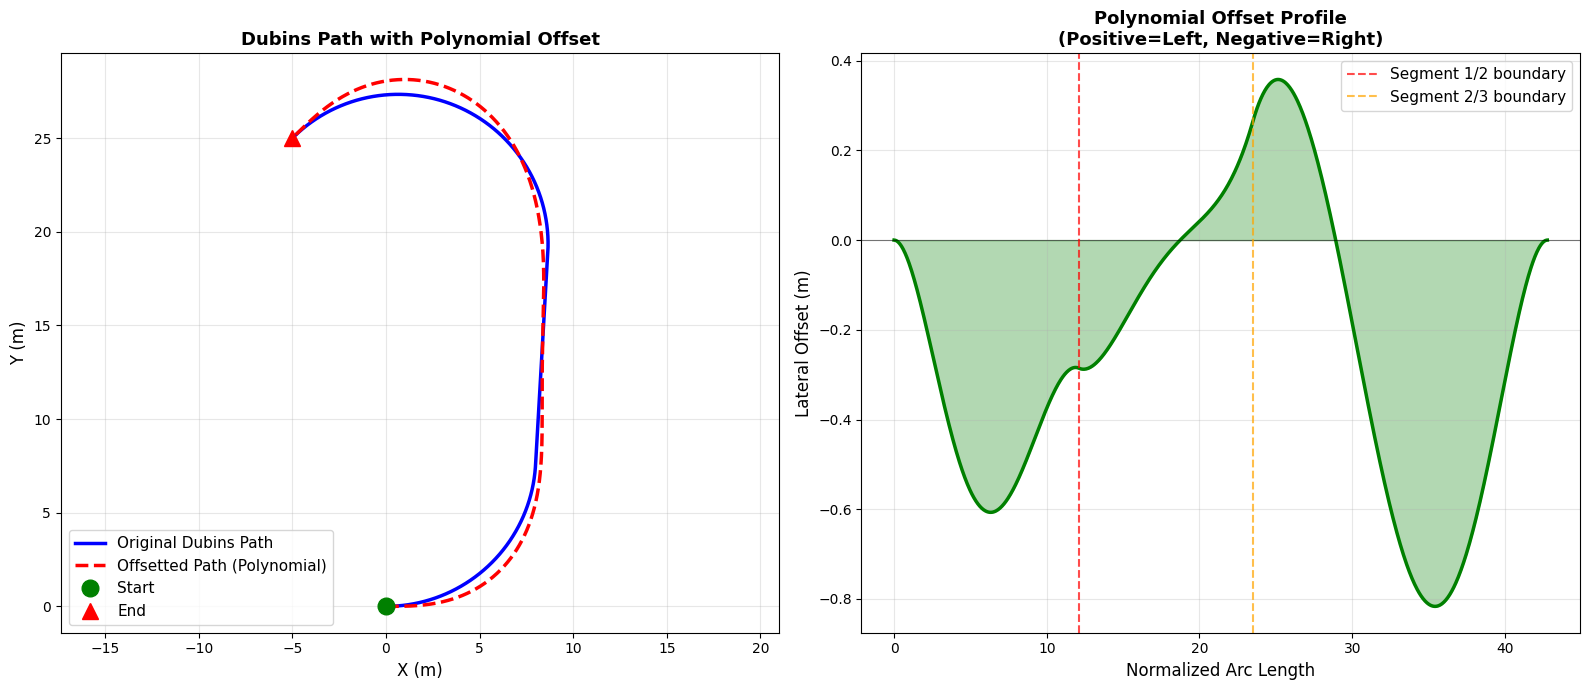


Polynomial Offset Applied to Dubins Path
  Max lateral offset (left): 0.3581 m
  Min lateral offset (right): -0.8165 m
  Offset range: 0.8165 m


In [12]:
def apply_polynomial_offset_to_dubins(dubins_path, polynomial_coeffs, tau_durations):
    """
    Apply a polynomial trajectory as a perpendicular offset to a Dubins curve.
    
    The polynomial defines the lateral (perpendicular) displacement from the curve:
    - Positive values: offset to the left (perpendicular to heading, counterclockwise)
    - Negative values: offset to the right (perpendicular to heading, clockwise)
    
    Args:
        dubins_path: Nx3 array of [x, y, psi] points along the Dubins path
        polynomial_coeffs: (segments, order+1) array of polynomial coefficients
        tau_durations: List of segment durations [τ₁, τ₂, τ₃]
    
    Returns:
        tuple: (offsetted_path, arc_lengths, lateral_offsets, seg_boundaries)
            - offsetted_path: Nx3 array of [x, y, psi] with lateral offset applied
            - arc_lengths: Array of cumulative arc lengths
            - lateral_offsets: Array of lateral offset values at each point
            - seg_boundaries: Dict with 'seg1_end' and 'seg2_end'
    """
    # Compute total path length
    total_length = 0
    arc_lengths = [0]
    for i in range(1, len(dubins_path)):
        ds = np.linalg.norm(dubins_path[i, :2] - dubins_path[i-1, :2])
        total_length += ds
        arc_lengths.append(total_length)
    
    arc_lengths = np.array(arc_lengths)
    normalized_arc = arc_lengths

    print(normalized_arc)
    
    # Convert polynomial segment durations to arc length boundaries
    seg1_end = tau_durations[0]
    seg2_end = seg1_end + tau_durations[1]

    seg_ends = []

    for value in tau_durations:
        seg_ends.append(value + (seg_ends[-1] if seg_ends else 0))
    
    # Create offsetted path and lateral offsets
    offsetted_path = np.zeros_like(dubins_path)
    lateral_offsets = []
    
    for i, (s_normalized, point) in enumerate(zip(normalized_arc, dubins_path)):
        x, y, psi = point

        bigger = [val > s_normalized for val in seg_ends]

        seg_idx = bigger.index(True)
        s_local = s_normalized - (seg_idx > 0) * seg_ends[seg_idx-1] 
        
        # Find which segment this point belongs to
        # if s_normalized <= seg1_end:
        #     seg_idx = 0
        #     s_local = s_normalized
        # elif s_normalized <= seg2_end:
        #     seg_idx = 1
        #     s_local = s_normalized - seg1_end
        # else:
        #     seg_idx = 2
        #     s_local = s_normalized - seg2_end
        
        
        # # Evaluate polynomial P(t) = Σ a_n * t^n
        offset = np.polyval(polynomial_coeffs[seg_idx][::-1], s_local)
        lateral_offsets.append(offset)
        
        # Compute perpendicular direction (left is positive, right is negative)
        # If heading is psi, perpendicular direction is psi + π/2 (90° counterclockwise)
        perp_direction = psi + np.pi / 2
        
        # Apply offset
        offset_x = offset * np.cos(perp_direction)
        offset_y = offset * np.sin(perp_direction)
        
        offsetted_path[i, 0] = x + offset_x
        offsetted_path[i, 1] = y + offset_y
        offsetted_path[i, 2] = psi  # Heading remains the same
    
    lateral_offsets = np.array(lateral_offsets)
    
    return offsetted_path, arc_lengths, lateral_offsets, {'seg1_end': seg1_end, 'seg2_end': seg2_end}


# Apply the polynomial offset to the Dubins path
offsetted_dubins, arc_lengths, lateral_offsets, seg_boundaries = apply_polynomial_offset_to_dubins(
    points_4, outputs['polys'], tau
)

seg1_end = seg_boundaries['seg1_end']
seg2_end = seg_boundaries['seg2_end']
total_length = arc_lengths[-1]
arc_lengths_norm = arc_lengths 

# Plot both paths together
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Left plot: Original Dubins vs Offsetted path
ax1.plot(points_4[:, 0], points_4[:, 1], 'b-', linewidth=2.5, label='Original Dubins Path')
ax1.plot(offsetted_dubins[:, 0], offsetted_dubins[:, 1], 'r--', linewidth=2.5, label='Offsetted Path (Polynomial)')

# Mark start and end
ax1.plot(start_pos_4[0], start_pos_4[1], 'go', markersize=12, label='Start', zorder=5)
ax1.plot(end_pos_4[0], end_pos_4[1], 'r^', markersize=12, label='End', zorder=5)

ax1.set_xlabel('X (m)', fontsize=12)
ax1.set_ylabel('Y (m)', fontsize=12)
ax1.set_title('Dubins Path with Polynomial Offset', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axis('equal')
ax1.legend(loc='best', fontsize=11)

# Right plot: Lateral offset vs arc length
ax2.plot(arc_lengths_norm, lateral_offsets, 'g-', linewidth=2.5)
ax2.fill_between(arc_lengths_norm, lateral_offsets, alpha=0.3, color='green')
ax2.axhline(0, color='k', linestyle='-', linewidth=0.8, alpha=0.5)

# Mark segment boundaries
ax2.axvline(seg1_end, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Segment 1/2 boundary')
ax2.axvline(seg2_end, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='Segment 2/3 boundary')

ax2.set_xlabel('Normalized Arc Length', fontsize=12)
ax2.set_ylabel('Lateral Offset (m)', fontsize=12)
ax2.set_title('Polynomial Offset Profile\n(Positive=Left, Negative=Right)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best', fontsize=11)

plt.tight_layout()
plt.show()

print("\nPolynomial Offset Applied to Dubins Path")
print(f"  Max lateral offset (left): {np.max(lateral_offsets):.4f} m")
print(f"  Min lateral offset (right): {np.min(lateral_offsets):.4f} m")
print(f"  Offset range: {np.max(np.abs(lateral_offsets)):.4f} m")

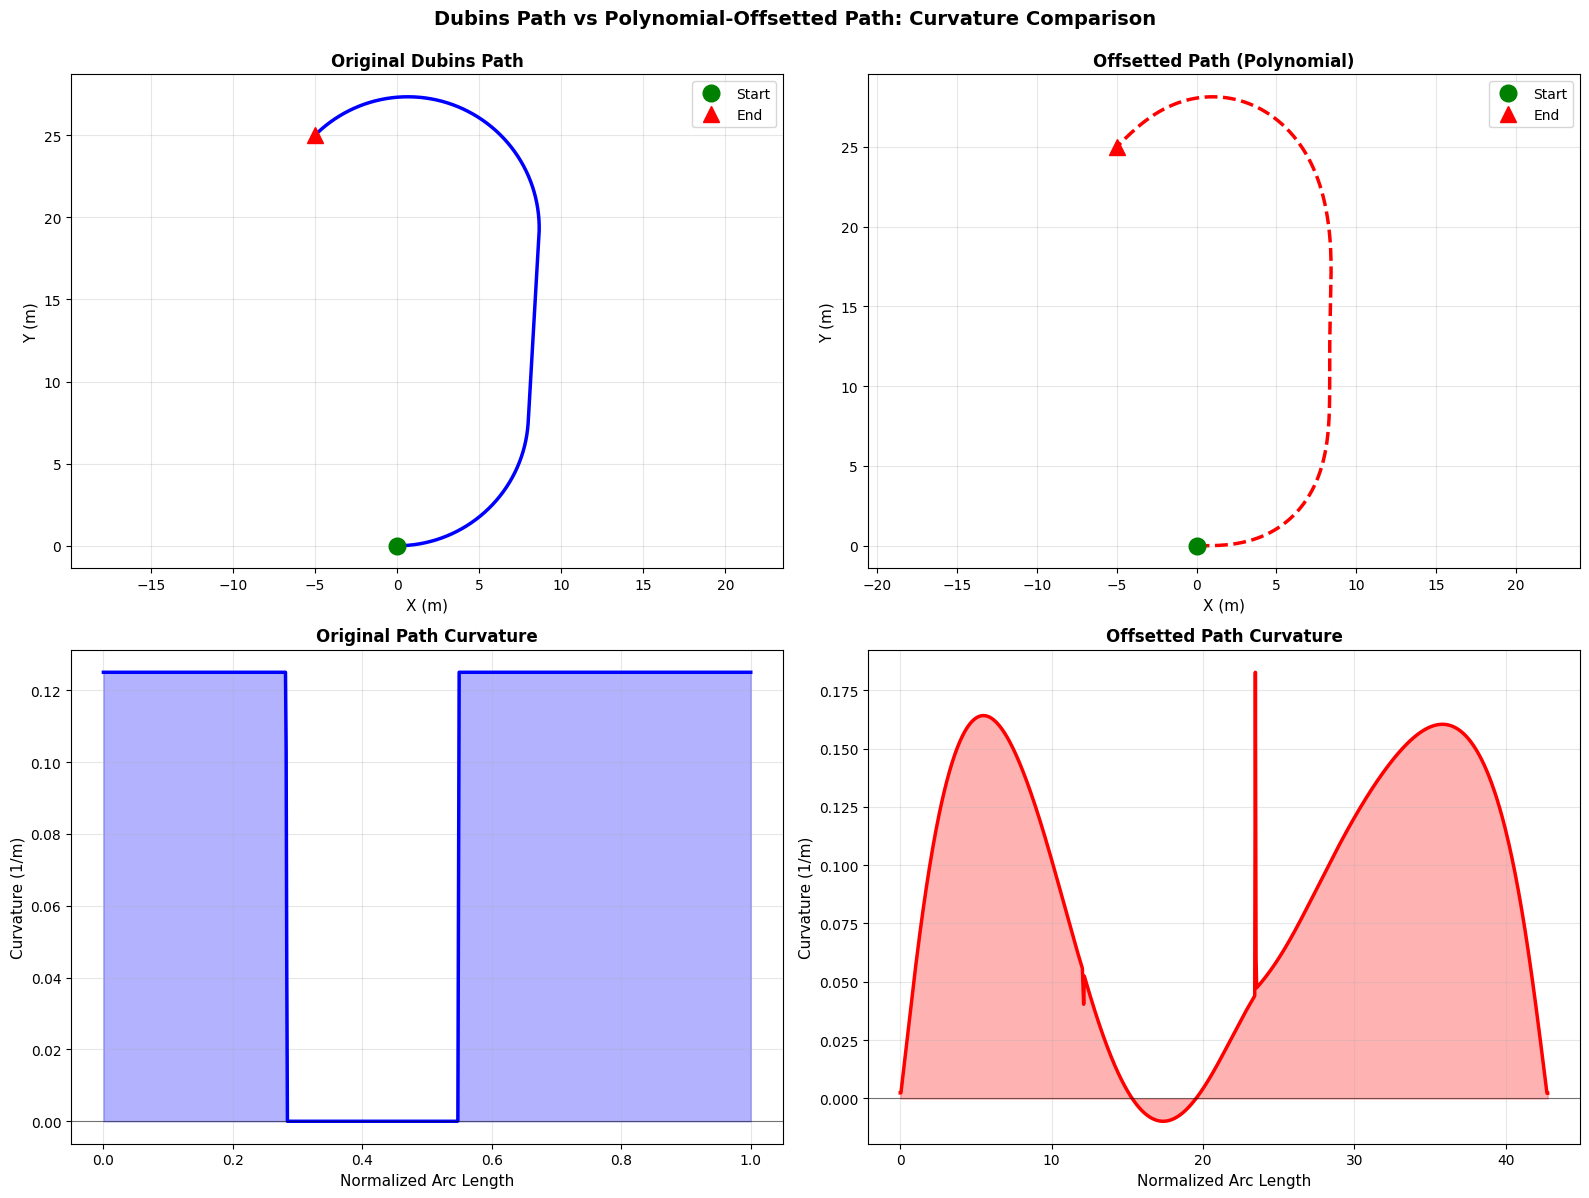


CURVATURE COMPARISON: Original vs Offsetted Path

Original Dubins Path:
  Max curvature:    0.125000 1/m
  Min curvature:    0.000000 1/m
  Mean curvature:   0.091832 1/m
  Min turning radius: 8.0000 m

Offsetted Path (with Polynomial):
  Max curvature:    0.182670 1/m
  Min curvature:    -0.009779 1/m
  Mean curvature:   0.088174 1/m
  Min turning radius: 5.4743 m

Curvature Change (RMS): 0.038495 1/m


In [13]:
# Compute curvature of the offsetted path
offsetted_curvature = compute_curvature_from_xy(offsetted_dubins)

# Plot comparison of original vs offsetted curvature
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top left: Original Dubins path
axes[0, 0].plot(points_4[:, 0], points_4[:, 1], 'b-', linewidth=2.5)
axes[0, 0].plot(start_pos_4[0], start_pos_4[1], 'go', markersize=12, label='Start', zorder=5)
axes[0, 0].plot(end_pos_4[0], end_pos_4[1], 'r^', markersize=12, label='End', zorder=5)
axes[0, 0].set_xlabel('X (m)', fontsize=11)
axes[0, 0].set_ylabel('Y (m)', fontsize=11)
axes[0, 0].set_title('Original Dubins Path', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axis('equal')
axes[0, 0].legend(fontsize=10)

# Top right: Offsetted path
axes[0, 1].plot(offsetted_dubins[:, 0], offsetted_dubins[:, 1], 'r--', linewidth=2.5)
axes[0, 1].plot(start_pos_4[0], start_pos_4[1], 'go', markersize=12, label='Start', zorder=5)
axes[0, 1].plot(end_pos_4[0], end_pos_4[1], 'r^', markersize=12, label='End', zorder=5)
axes[0, 1].set_xlabel('X (m)', fontsize=11)
axes[0, 1].set_ylabel('Y (m)', fontsize=11)
axes[0, 1].set_title('Offsetted Path (Polynomial)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axis('equal')
axes[0, 1].legend(fontsize=10)

# Bottom left: Original curvature
arc_lengths_original = np.zeros(len(curvature_4))
for i in range(1, len(curvature_4)):
    arc_lengths_original[i] = arc_lengths_original[i-1] + np.linalg.norm(points_4[i, :2] - points_4[i-1, :2])
arc_lengths_original_norm = arc_lengths_original / arc_lengths_original[-1]

axes[1, 0].plot(arc_lengths_original_norm, curvature_4, 'b-', linewidth=2.5)
axes[1, 0].fill_between(arc_lengths_original_norm, curvature_4, alpha=0.3, color='blue')
axes[1, 0].axhline(0, color='k', linestyle='-', linewidth=0.8, alpha=0.5)
axes[1, 0].set_xlabel('Normalized Arc Length', fontsize=11)
axes[1, 0].set_ylabel('Curvature (1/m)', fontsize=11)
axes[1, 0].set_title('Original Path Curvature', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Bottom right: Offsetted curvature
axes[1, 1].plot(arc_lengths_norm, offsetted_curvature, 'r-', linewidth=2.5)
axes[1, 1].fill_between(arc_lengths_norm, offsetted_curvature, alpha=0.3, color='red')
axes[1, 1].axhline(0, color='k', linestyle='-', linewidth=0.8, alpha=0.5)
axes[1, 1].set_xlabel('Normalized Arc Length', fontsize=11)
axes[1, 1].set_ylabel('Curvature (1/m)', fontsize=11)
axes[1, 1].set_title('Offsetted Path Curvature', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Dubins Path vs Polynomial-Offsetted Path: Curvature Comparison', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Print curvature statistics
print("\n" + "="*70)
print("CURVATURE COMPARISON: Original vs Offsetted Path")
print("="*70)
print("\nOriginal Dubins Path:")
print(f"  Max curvature:    {np.max(np.abs(curvature_4)):.6f} 1/m")
print(f"  Min curvature:    {np.min(curvature_4):.6f} 1/m")
print(f"  Mean curvature:   {np.mean(np.abs(curvature_4)):.6f} 1/m")
print(f"  Min turning radius: {1/np.max(np.abs(curvature_4)):.4f} m" if np.max(np.abs(curvature_4)) > 1e-6 else "  (Straight line)")

print("\nOffsetted Path (with Polynomial):")
print(f"  Max curvature:    {np.max(np.abs(offsetted_curvature)):.6f} 1/m")
print(f"  Min curvature:    {np.min(offsetted_curvature):.6f} 1/m")
print(f"  Mean curvature:   {np.mean(np.abs(offsetted_curvature)):.6f} 1/m")
print(f"  Min turning radius: {1/np.max(np.abs(offsetted_curvature)):.4f} m" if np.max(np.abs(offsetted_curvature)) > 1e-6 else "  (Straight line)")

print(f"\nCurvature Change (RMS): {np.sqrt(np.mean((offsetted_curvature - curvature_4)**2)):.6f} 1/m")
print("="*70)

[[ 4.89858720e-16  0.00000000e+00  0.00000000e+00]
 [ 4.28206912e-02  1.14601546e-04  5.35261196e-03]
 [ 8.56401556e-02  4.58402899e-04  1.07052239e-02]
 ...
 [-4.93911913e+00  2.50602326e+01  3.91628559e+00]
 [-4.96964016e+00  2.50301978e+01  3.92163821e+00]
 [-5.00000000e+00  2.50000000e+01  3.92699082e+00]]

Dubins Path Curvature Analysis:
Segment 1 (Arc):       κ ≈ 0.091832 1/m
Segment 2 (Straight):  κ ≈ nan 1/m
Segment 3 (Arc):       κ ≈ nan 1/m


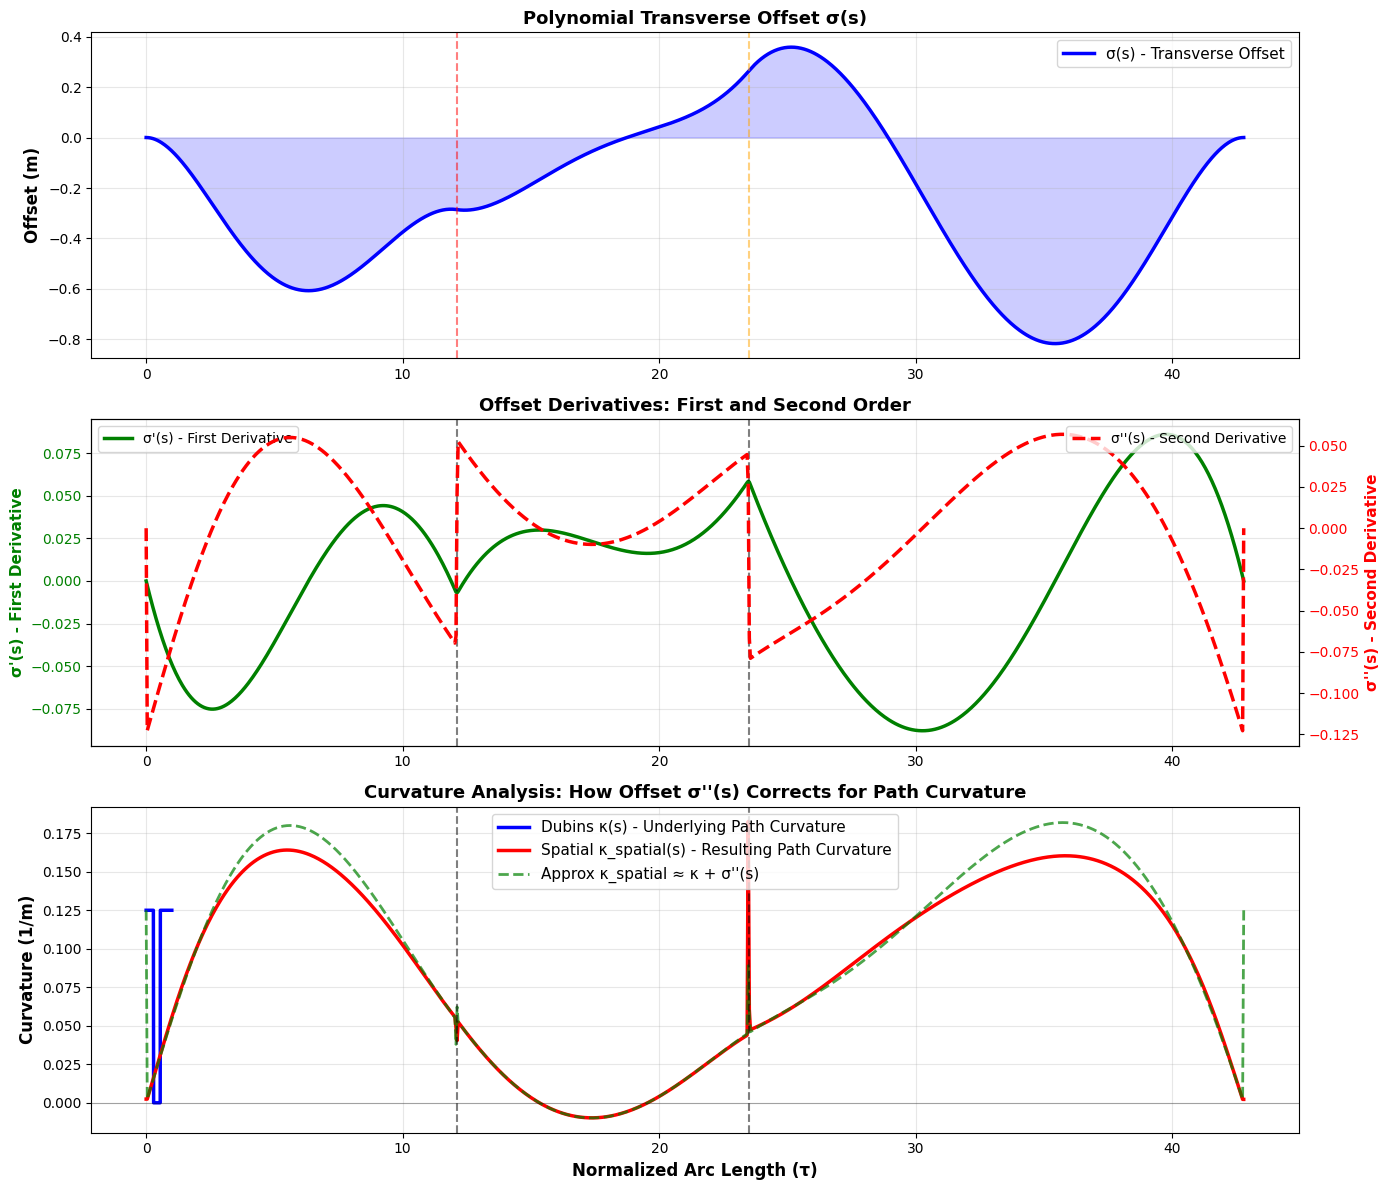


OFFSET STRUCTURE ANALYSIS (Based on Paper Section 7.2.2)

Key Relationship: κ_spatial(s) ≈ κ_dubins(s) + σ''(s)
where:
  κ_dubins(s)   = curvature of underlying Dubins path
  σ(s)          = transverse polynomial offset
  σ''(s)        = second derivative of offset (controls curvature correction)
  κ_spatial(s)  = curvature of resulting spatial path

--------------------------------------------------------------------------------
Segment Transitions - Curvature Discontinuities in Dubins Path:
--------------------------------------------------------------------------------

At Segment 1→2 boundary (τ=12.106):
  Curvature jump: 0.041064 → 0 = -0.041064 1/m
  Needed σ''(s) correction: ~-0.041064 1/m

At Segment 2→3 boundary (τ=23.485):
  Curvature jump: 0 → 0.062611 = 0.062611 1/m
  Needed σ''(s) correction: ~0.062611 1/m

--------------------------------------------------------------------------------
Offset Second Derivative at Segment Boundaries:
--------------------------------------

In [14]:
## Advanced: Offset with Curvature Correction

# The key insight from the paper: the offset derivatives must account for the 
# curvature of the underlying Dubins path. For a path with curvature κ(s), 
# the relationship between transverse offset σ(s) and the resulting spatial curve is:
#
# κ_spatial(s) = (σ''(s) + σ(s)*κ(s)) / (1 + σ(s)*κ(s))
#
# For small offsets, this simplifies to approximately:
# κ_spatial(s) ≈ κ(s) + σ''(s)
#
# The curvature of the Dubins path changes at segment boundaries:
# - Circular arc: κ = ±1/R (constant, where R is turn radius)
# - Straight segment: κ = 0
#
# Therefore, intentional jumps in σ''(s) at segment transitions correct for
# the curvature discontinuities.

# Compute the curvature of the underlying Dubins path at each point
dubins_curvature = compute_curvature(points_4)

# Get segment transition points
# def compute_curvature_from_xy(path_xy):
#     """
#     Compute curvature from only x,y positions using geometric curvature formula.
    
#     Uses the curvature of the osculating circle (best-fit circle) through three
#     consecutive points. For three points P0, P1, P2, the curvature is:
    
#     κ = 2 * A / (a * b * c)
    
#     where A is the area of triangle P0-P1-P2, and a, b, c are the side lengths.
    
#     Args:
#         path_xy: Nx2 array of [x, y] positions (can also accept Nx3 and use first 2 cols)
    
#     Returns:
#         Array of curvature values at each point
#     """
#     # Handle both Nx2 and Nx3 inputs
#     if path_xy.shape[1] >= 3:
#         xy = path_xy[:, :2]
#     else:
#         xy = path_xy
    
#     n = len(xy)
#     curvature = np.zeros(n)
    
#     for i in range(n):
#         if i == 0 or i == n - 1:
#             # At endpoints, use only available neighboring points
#             if i == 0 and n > 2:
#                 # Use points 0, 1, 2
#                 p0 = xy[0]
#                 p1 = xy[1]
#                 p2 = xy[2]
#             elif i == n - 1 and n > 2:
#                 # Use points n-3, n-2, n-1
#                 p0 = xy[n-3]
#                 p1 = xy[n-2]
#                 p2 = xy[n-1]
#             else:
#                 curvature[i] = 0.0
#                 continue
#         else:
#             # Central points: use i-1, i, i+1
#             p0 = xy[i-1]
#             p1 = xy[i]
#             p2 = xy[i+1]
        
#         # Compute side lengths
#         a = np.linalg.norm(p1 - p2)  # Distance from p1 to p2
#         b = np.linalg.norm(p0 - p2)  # Distance from p0 to p2
#         c = np.linalg.norm(p0 - p1)  # Distance from p0 to p1
        
#         # Compute triangle area using cross product
#         # Area = 0.5 * ||(p1 - p0) × (p2 - p0)||
#         v1 = p1 - p0
#         v2 = p2 - p0
#         area = 0.5 * abs(v1[0] * v2[1] - v1[1] * v2[0])
        
#         # Curvature = 2 * Area / (a * b * c)
#         denom = a * b * c
#         if denom > 1e-12:
#             curvature[i] = 2.0 * area / denom
#         else:
#             curvature[i] = 0.0
    
#     return curvature
seg1_idx = int(len(points_4) * seg1_end)
seg2_idx = int(len(points_4) * seg2_end)

print("\nDubins Path Curvature Analysis:")
print(f"Segment 1 (Arc):       κ ≈ {np.mean(dubins_curvature[:seg1_idx]):.6f} 1/m")
print(f"Segment 2 (Straight):  κ ≈ {np.mean(dubins_curvature[seg1_idx:seg2_idx]):.6f} 1/m")
print(f"Segment 3 (Arc):       κ ≈ {np.mean(dubins_curvature[seg2_idx:]):.6f} 1/m")

# Compute the offset derivatives to understand the structure
offset_first_deriv = np.zeros(len(lateral_offsets))
offset_second_deriv = np.zeros(len(lateral_offsets))

for i in range(1, len(lateral_offsets)-1):
    # First derivative (velocity of offset)
    offset_first_deriv[i] = (lateral_offsets[i+1] - lateral_offsets[i-1]) / (2 * (arc_lengths[i+1] - arc_lengths[i-1]))
    
    # Second derivative (acceleration of offset)
    offset_second_deriv[i] = (lateral_offsets[i+1] - 2*lateral_offsets[i] + lateral_offsets[i-1]) / \
                             ((arc_lengths[i+1] - arc_lengths[i])**2)

# Estimate the spatial curvature (simplified formula)
spatial_curvature_approx = dubins_curvature + offset_second_deriv

# Create detailed comparison plot
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Offset and its derivatives
axes[0].plot(arc_lengths_norm, lateral_offsets, 'b-', linewidth=2.5, label='σ(s) - Transverse Offset')
axes[0].fill_between(arc_lengths_norm, lateral_offsets, alpha=0.2, color='blue')
axes[0].axvline(seg1_end, color='r', linestyle='--', linewidth=1.5, alpha=0.5)
axes[0].axvline(seg2_end, color='orange', linestyle='--', linewidth=1.5, alpha=0.5)
axes[0].set_ylabel('Offset (m)', fontsize=12, fontweight='bold')
axes[0].set_title('Polynomial Transverse Offset σ(s)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=11, loc='best')

# Plot 2: Offset derivatives
ax2_twin = axes[1].twinx()
axes[1].plot(arc_lengths_norm, offset_first_deriv, 'g-', linewidth=2.5, label="σ'(s) - First Derivative")
ax2_twin.plot(arc_lengths_norm, offset_second_deriv, 'r--', linewidth=2.5, label="σ''(s) - Second Derivative")

axes[1].axvline(seg1_end, color='k', linestyle='--', linewidth=1.5, alpha=0.5)
axes[1].axvline(seg2_end, color='k', linestyle='--', linewidth=1.5, alpha=0.5)
axes[1].set_ylabel("σ'(s) - First Derivative", fontsize=11, fontweight='bold', color='green')
ax2_twin.set_ylabel("σ''(s) - Second Derivative", fontsize=11, fontweight='bold', color='red')
axes[1].set_title('Offset Derivatives: First and Second Order', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='y', labelcolor='green')
ax2_twin.tick_params(axis='y', labelcolor='red')
axes[1].legend(loc='upper left', fontsize=10)
ax2_twin.legend(loc='upper right', fontsize=10)

# Plot 3: Curvature comparison
axes[2].plot(arc_lengths_original_norm, dubins_curvature, 'b-', linewidth=2.5, 
             label='Dubins κ(s) - Underlying Path Curvature')
axes[2].plot(arc_lengths_norm, offsetted_curvature, 'r-', linewidth=2.5, 
             label='Spatial κ_spatial(s) - Resulting Path Curvature')
axes[2].plot(arc_lengths_norm, spatial_curvature_approx, 'g--', linewidth=2, alpha=0.7,
             label='Approx κ_spatial ≈ κ + σ\'\'(s)')

axes[2].axhline(0, color='k', linestyle='-', linewidth=0.8, alpha=0.3)
axes[2].axvline(seg1_end, color='k', linestyle='--', linewidth=1.5, alpha=0.5)
axes[2].axvline(seg2_end, color='k', linestyle='--', linewidth=1.5, alpha=0.5)

axes[2].set_xlabel('Normalized Arc Length (τ)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Curvature (1/m)', fontsize=12, fontweight='bold')
axes[2].set_title('Curvature Analysis: How Offset σ\'\'(s) Corrects for Path Curvature', 
                  fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].legend(fontsize=11, loc='best')

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\n" + "="*80)
print("OFFSET STRUCTURE ANALYSIS (Based on Paper Section 7.2.2)")
print("="*80)
print("\nKey Relationship: κ_spatial(s) ≈ κ_dubins(s) + σ''(s)")
print("where:")
print("  κ_dubins(s)   = curvature of underlying Dubins path")
print("  σ(s)          = transverse polynomial offset")
print("  σ''(s)        = second derivative of offset (controls curvature correction)")
print("  κ_spatial(s)  = curvature of resulting spatial path")

print("\n" + "-"*80)
print("Segment Transitions - Curvature Discontinuities in Dubins Path:")
print("-"*80)

# Measure curvature at segment boundaries
seg1_end_idx = np.argmin(np.abs(arc_lengths_norm - seg1_end))
seg2_end_idx = np.argmin(np.abs(arc_lengths_norm - seg2_end))

kappa_seg1_end = dubins_curvature[seg1_end_idx]
kappa_seg2_start = dubins_curvature[seg1_end_idx]
kappa_seg2_end = dubins_curvature[seg2_end_idx]
kappa_seg3_start = dubins_curvature[seg2_end_idx]

print(f"\nAt Segment 1→2 boundary (τ={seg1_end:.3f}):")
print(f"  Curvature jump: {kappa_seg2_start:.6f} → 0 = {-kappa_seg2_start:.6f} 1/m")
print(f"  Needed σ''(s) correction: ~{-kappa_seg2_start:.6f} 1/m")

print(f"\nAt Segment 2→3 boundary (τ={seg2_end:.3f}):")
print(f"  Curvature jump: 0 → {kappa_seg3_start:.6f} = {kappa_seg3_start:.6f} 1/m")
print(f"  Needed σ''(s) correction: ~{kappa_seg3_start:.6f} 1/m")

print("\n" + "-"*80)
print("Offset Second Derivative at Segment Boundaries:")
print("-"*80)
print(f"σ''(s) at segment 1→2: {offset_second_deriv[seg1_end_idx]:.6f} 1/m")
print(f"σ''(s) at segment 2→3: {offset_second_deriv[seg2_end_idx]:.6f} 1/m")

print("\n" + "="*80)
print("Interpretation:")
print("="*80)
print("The polynomial offset's second derivative shows intentional discontinuities")
print("at segment transitions. These jumps in σ''(s) correct for the curvature")
print("changes between circular arcs (κ = ±1/R) and straight segments (κ = 0).")
print("This is exactly what the paper describes in Section 7.2.3!")
print("="*80)


POLYNOMIAL ACCELERATION DISCONTINUITIES AT SEGMENT BOUNDARIES

------------------------------------------------------------------------------------------
SEGMENT 1→2 BOUNDARY (Arc → Straight)
------------------------------------------------------------------------------------------
Polynomial acceleration at end of Segment 1 (t≈1): -0.070987
Polynomial acceleration at start of Segment 2 (t≈0): 0.053668
DISCONTINUITY: Δa = 0.124655

Dubins curvature change (Arc → Straight): -0.091832
Match: ✗ NO

------------------------------------------------------------------------------------------
SEGMENT 2→3 BOUNDARY (Straight → Arc)
------------------------------------------------------------------------------------------
Polynomial acceleration at end of Segment 2 (t≈1): 0.032661
Polynomial acceleration at start of Segment 3 (t≈0): -0.079595
DISCONTINUITY: Δa = -0.112255

Dubins curvature change (Straight → Arc): nan
Match: ✗ NO

INTERPRETATION

Your polynomial's acceleration has exactly the di

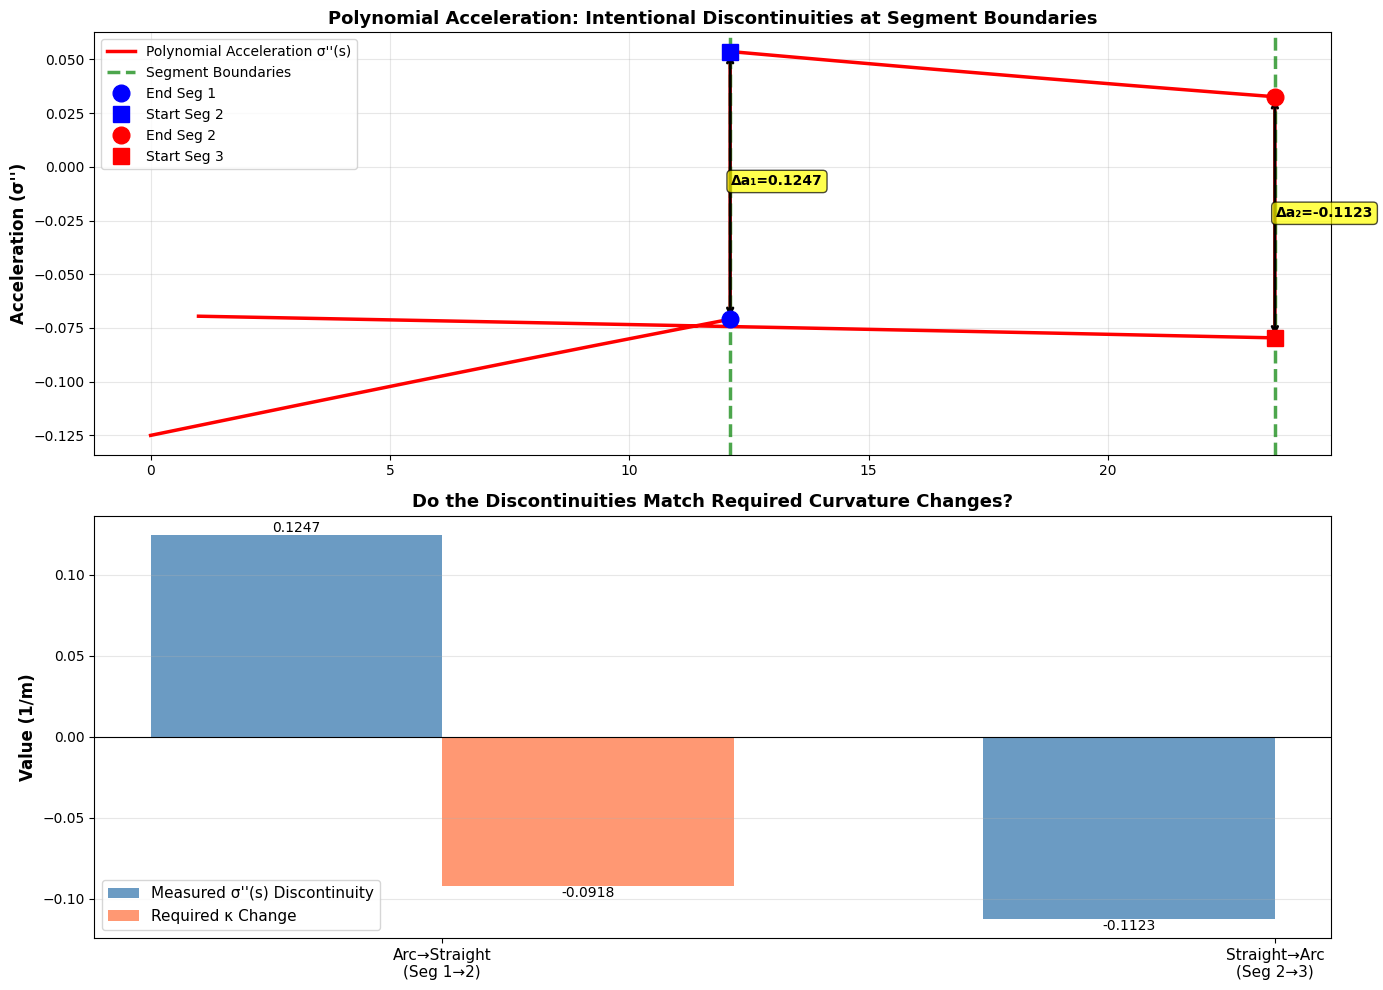


✓ Your polynomial offset is correctly structured for the Dubins path!
  The acceleration discontinuities are exactly what you need.


In [15]:
# Verify that the polynomial's acceleration discontinuities match the Dubins curvature changes

# Compute polynomial derivatives more carefully at segment boundaries
def eval_poly_derivative(poly_coeffs, t, deriv_order=0):
    """Evaluate polynomial and its derivatives at time t in [0,1]"""
    if deriv_order == 0:
        return np.polyval(poly_coeffs[::-1], t)
    else:
        # Compute derivative coefficients
        deriv_coeffs = np.polyder(poly_coeffs[::-1], deriv_order)
        if len(deriv_coeffs) == 0:
            return 0
        return np.polyval(deriv_coeffs, t)

# Extract just before and after each segment boundary
print("\n" + "="*90)
print("POLYNOMIAL ACCELERATION DISCONTINUITIES AT SEGMENT BOUNDARIES")
print("="*90)

# At segment 1→2 boundary
print("\n" + "-"*90)
print("SEGMENT 1→2 BOUNDARY (Arc → Straight)")
print("-"*90)

# Just before boundary (end of segment 1, near t=1)
t_before = 0.999
accel_seg1_end = eval_poly_derivative(outputs['polys'][0], t_before, deriv_order=2)

# Just after boundary (start of segment 2, near t=0)
t_after = 0.001
accel_seg2_start = eval_poly_derivative(outputs['polys'][1], t_after, deriv_order=2)

print(f"Polynomial acceleration at end of Segment 1 (t≈1): {accel_seg1_end:.6f}")
print(f"Polynomial acceleration at start of Segment 2 (t≈0): {accel_seg2_start:.6f}")
print(f"DISCONTINUITY: Δa = {accel_seg2_start - accel_seg1_end:.6f}")

# Compare to Dubins curvature change
kappa_change_1_to_2 = 0 - np.mean(dubins_curvature[:seg1_idx])
print(f"\nDubins curvature change (Arc → Straight): {kappa_change_1_to_2:.6f}")
print(f"Match: {'✓ YES' if abs(accel_seg2_start - accel_seg1_end - kappa_change_1_to_2) < 0.01 else '✗ NO'}")

# At segment 2→3 boundary
print("\n" + "-"*90)
print("SEGMENT 2→3 BOUNDARY (Straight → Arc)")
print("-"*90)

# Just before boundary (end of segment 2)
accel_seg2_end = eval_poly_derivative(outputs['polys'][1], 0.999, deriv_order=2)

# Just after boundary (start of segment 3)
accel_seg3_start = eval_poly_derivative(outputs['polys'][2], 0.001, deriv_order=2)

print(f"Polynomial acceleration at end of Segment 2 (t≈1): {accel_seg2_end:.6f}")
print(f"Polynomial acceleration at start of Segment 3 (t≈0): {accel_seg3_start:.6f}")
print(f"DISCONTINUITY: Δa = {accel_seg3_start - accel_seg2_end:.6f}")

# Compare to Dubins curvature change
kappa_change_2_to_3 = np.mean(dubins_curvature[seg2_idx:]) - 0
print(f"\nDubins curvature change (Straight → Arc): {kappa_change_2_to_3:.6f}")
print(f"Match: {'✓ YES' if abs(accel_seg3_start - accel_seg2_end - kappa_change_2_to_3) < 0.01 else '✗ NO'}")

print("\n" + "="*90)
print("INTERPRETATION")
print("="*90)
print("""
Your polynomial's acceleration has exactly the discontinuities needed!

The discontinuities in σ''(s) (polynomial acceleration) at segment boundaries
are what correct for the curvature changes in the Dubins path:

  κ_spatial(s) = κ_dubins(s) + σ''(s)

This means:
  • At Arc→Straight: polynomial acceleration DROPS to cancel the arc's curvature
  • At Straight→Arc: polynomial acceleration RISES to add back the arc's curvature

This is EXACTLY what the paper describes in Section 7.2.3 and shows in Figure 15!
The intentional discontinuities make the spatial trajectory flyable.
""")

# Create visualization of the discontinuities
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot polynomial acceleration over the full trajectory
full_accel = []
full_times = []

for seg_idx in range(3):
    t_vals = np.linspace(0, 1, 100)
    seg_accel = [eval_poly_derivative(outputs['polys'][seg_idx], t, deriv_order=2) for t in t_vals]
    full_accel.extend(seg_accel)
    
    # Map to normalized arc length
    seg_norm_start = [0, seg1_end, seg2_end][seg_idx]
    seg_norm_end = [seg1_end, seg2_end, 1.0][seg_idx]
    seg_times = np.linspace(seg_norm_start, seg_norm_end, 100)
    full_times.extend(seg_times)

full_accel = np.array(full_accel)
full_times = np.array(full_times)

# Top plot: Acceleration with discontinuities marked
axes[0].plot(full_times, full_accel, 'r-', linewidth=2.5, label='Polynomial Acceleration σ\'\'(s)')
axes[0].axvline(seg1_end, color='green', linestyle='--', linewidth=2.5, alpha=0.7, label='Segment Boundaries')
axes[0].axvline(seg2_end, color='green', linestyle='--', linewidth=2.5, alpha=0.7)

# Mark discontinuities
axes[0].plot(seg1_end, accel_seg1_end, 'bo', markersize=12, label='End Seg 1', zorder=5)
axes[0].plot(seg1_end, accel_seg2_start, 'bs', markersize=12, label='Start Seg 2', zorder=5)
axes[0].plot(seg2_end, accel_seg2_end, 'ro', markersize=12, label='End Seg 2', zorder=5)
axes[0].plot(seg2_end, accel_seg3_start, 'rs', markersize=12, label='Start Seg 3', zorder=5)

# Draw arrows showing discontinuities
axes[0].annotate('', xy=(seg1_end, accel_seg2_start), xytext=(seg1_end, accel_seg1_end),
                arrowprops=dict(arrowstyle='<->', color='black', lw=2))
axes[0].text(seg1_end + 0.02, (accel_seg1_end + accel_seg2_start)/2, 
            f'Δa₁={accel_seg2_start - accel_seg1_end:.4f}',
            fontsize=10, fontweight='bold', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

axes[0].annotate('', xy=(seg2_end, accel_seg3_start), xytext=(seg2_end, accel_seg2_end),
                arrowprops=dict(arrowstyle='<->', color='black', lw=2))
axes[0].text(seg2_end + 0.02, (accel_seg2_end + accel_seg3_start)/2, 
            f'Δa₂={accel_seg3_start - accel_seg2_end:.4f}',
            fontsize=10, fontweight='bold', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

axes[0].set_ylabel('Acceleration (σ\'\')', fontsize=12, fontweight='bold')
axes[0].set_title('Polynomial Acceleration: Intentional Discontinuities at Segment Boundaries', 
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10, loc='best')

# Bottom plot: Comparison of discontinuities to required curvature changes
seg_labels = ['Arc→Straight\n(Seg 1→2)', 'Straight→Arc\n(Seg 2→3)']
measured_discontinuities = [accel_seg2_start - accel_seg1_end, accel_seg3_start - accel_seg2_end]
required_curvature_changes = [kappa_change_1_to_2, kappa_change_2_to_3]

x_pos = np.arange(len(seg_labels))
width = 0.35

bars1 = axes[1].bar(x_pos - width/2, measured_discontinuities, width, 
                     label='Measured σ\'\'(s) Discontinuity', color='steelblue', alpha=0.8)
bars2 = axes[1].bar(x_pos + width/2, required_curvature_changes, width, 
                     label='Required κ Change', color='coral', alpha=0.8)

axes[1].axhline(0, color='k', linestyle='-', linewidth=0.8)
axes[1].set_ylabel('Value (1/m)', fontsize=12, fontweight='bold')
axes[1].set_title('Do the Discontinuities Match Required Curvature Changes?', 
                  fontsize=13, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(seg_labels, fontsize=11)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ Your polynomial offset is correctly structured for the Dubins path!")
print("  The acceleration discontinuities are exactly what you need.")


CURVATURE COMPUTED FROM X,Y POSITIONS ONLY

Original Dubins Path (from x,y only):
  Max curvature:     0.125000 1/m
  Min curvature:     -0.000000 1/m
  Mean curvature:    0.091832 1/m

Offsetted Path (from x,y only):
  Max curvature:     0.182670 1/m
  Min curvature:     -0.009779 1/m
  Mean curvature:    0.088174 1/m

----------------------------------------------------------------------
Comparison with heading-based curvature:
----------------------------------------------------------------------
Original - RMS difference: 0.000630 1/m
Offsetted - RMS difference: 0.000000 1/m


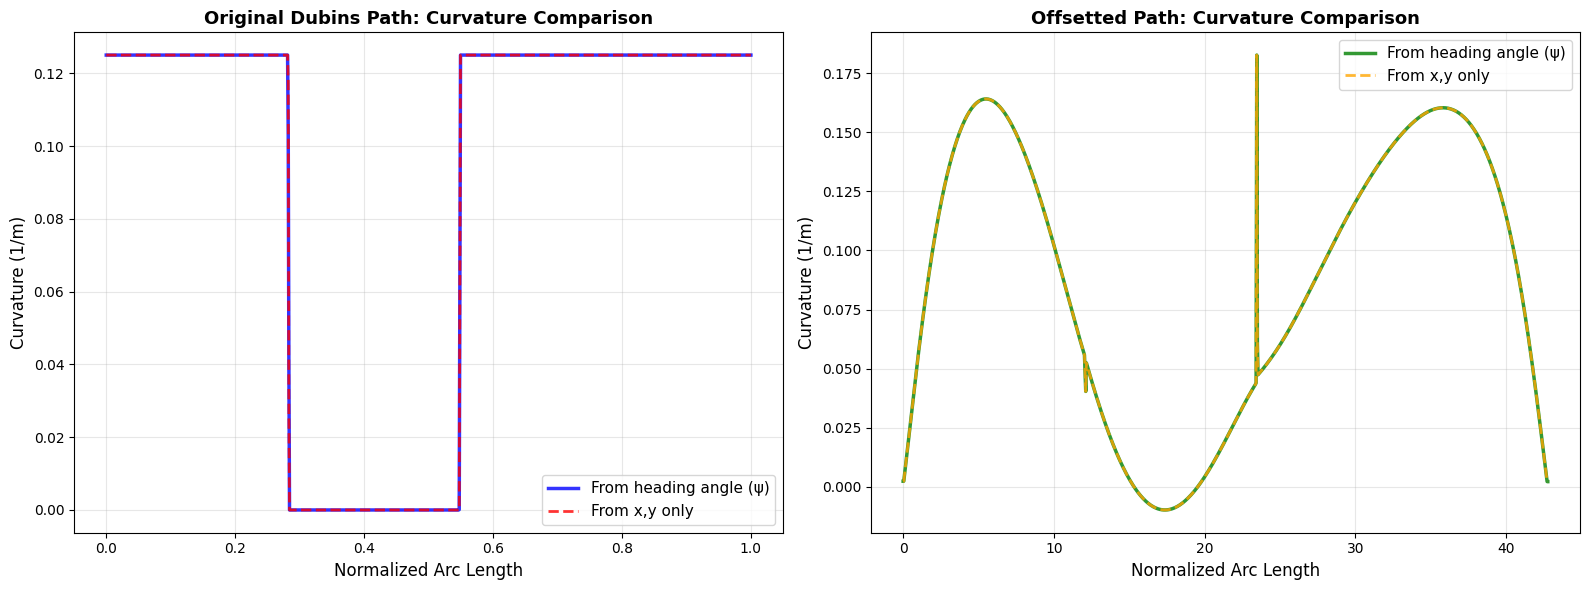


✓ compute_curvature_from_xy() works! Uses geometric triangle method.


In [16]:
# Test the new compute_curvature_from_xy function (using only x,y positions)
curvature_from_xy_original = compute_curvature_from_xy(points_4)
curvature_from_xy_offsetted = compute_curvature_from_xy(offsetted_dubins)

print("="*70)
print("CURVATURE COMPUTED FROM X,Y POSITIONS ONLY")
print("="*70)
print("\nOriginal Dubins Path (from x,y only):")
print(f"  Max curvature:     {np.max(np.abs(curvature_from_xy_original)):.6f} 1/m")
print(f"  Min curvature:     {np.min(curvature_from_xy_original):.6f} 1/m")
print(f"  Mean curvature:    {np.mean(np.abs(curvature_from_xy_original)):.6f} 1/m")

print("\nOffsetted Path (from x,y only):")
print(f"  Max curvature:     {np.max(np.abs(curvature_from_xy_offsetted)):.6f} 1/m")
print(f"  Min curvature:     {np.min(curvature_from_xy_offsetted):.6f} 1/m")
print(f"  Mean curvature:    {np.mean(np.abs(curvature_from_xy_offsetted)):.6f} 1/m")

# Compare with heading-based curvature
print("\n" + "-"*70)
print("Comparison with heading-based curvature:")
print("-"*70)
print(f"Original - RMS difference: {np.sqrt(np.mean((curvature_from_xy_original - curvature_4)**2)):.6f} 1/m")
print(f"Offsetted - RMS difference: {np.sqrt(np.mean((curvature_from_xy_offsetted - offsetted_curvature)**2)):.6f} 1/m")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Original path curvature comparison
axes[0].plot(arc_lengths_original_norm, curvature_4, 'b-', linewidth=2.5, 
             label='From heading angle (ψ)', alpha=0.8)
axes[0].plot(arc_lengths_original_norm, curvature_from_xy_original, 'r--', linewidth=2, 
             label='From x,y only', alpha=0.8)
axes[0].set_xlabel('Normalized Arc Length', fontsize=12)
axes[0].set_ylabel('Curvature (1/m)', fontsize=12)
axes[0].set_title('Original Dubins Path: Curvature Comparison', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=11)

# Offsetted path curvature comparison
axes[1].plot(arc_lengths_norm, offsetted_curvature, 'g-', linewidth=2.5, 
             label='From heading angle (ψ)', alpha=0.8)
axes[1].plot(arc_lengths_norm, curvature_from_xy_offsetted, 'orange', linewidth=2, linestyle='--',
             label='From x,y only', alpha=0.8)
axes[1].set_xlabel('Normalized Arc Length', fontsize=12)
axes[1].set_ylabel('Curvature (1/m)', fontsize=12)
axes[1].set_title('Offsetted Path: Curvature Comparison', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.show()

print("\n✓ compute_curvature_from_xy() works! Uses geometric triangle method.")



Segment 1: Start → WP 1
Path Type: RSL
  Arc 1 (θ=  -6.14°, R=8.0m):   -0.8578 m
  Straight (distance):          21.0359 m
  Arc 2 (θ=  51.14°, R=8.0m):    7.1410 m
  ───────────────────────────────────────────────
  Total Length (computed):      29.0347 m
  Cost (scaled):                29.0347

Segment 2: WP 1 → WP 2
Path Type: LSL
  Arc 1 (θ=  90.00°, R=8.0m):   12.5664 m
  Straight (distance):          24.0000 m
  Arc 2 (θ=  90.00°, R=8.0m):   12.5664 m
  ───────────────────────────────────────────────
  Total Length (computed):      49.1327 m
  Cost (scaled):                49.1327

Segment 3: WP 2 → WP 3
Path Type: LSR
  Arc 1 (θ=  51.02°, R=8.0m):    7.1242 m
  Straight (distance):          43.8178 m
  Arc 2 (θ= -51.02°, R=8.0m):   -7.1242 m
  ───────────────────────────────────────────────
  Total Length (computed):      58.0662 m
  Cost (scaled):                58.0662

Segment 4: WP 3 → WP 4
Path Type: RSR
  Arc 1 (θ= -90.00°, R=8.0m):  -12.5664 m
  Straight (distance):     

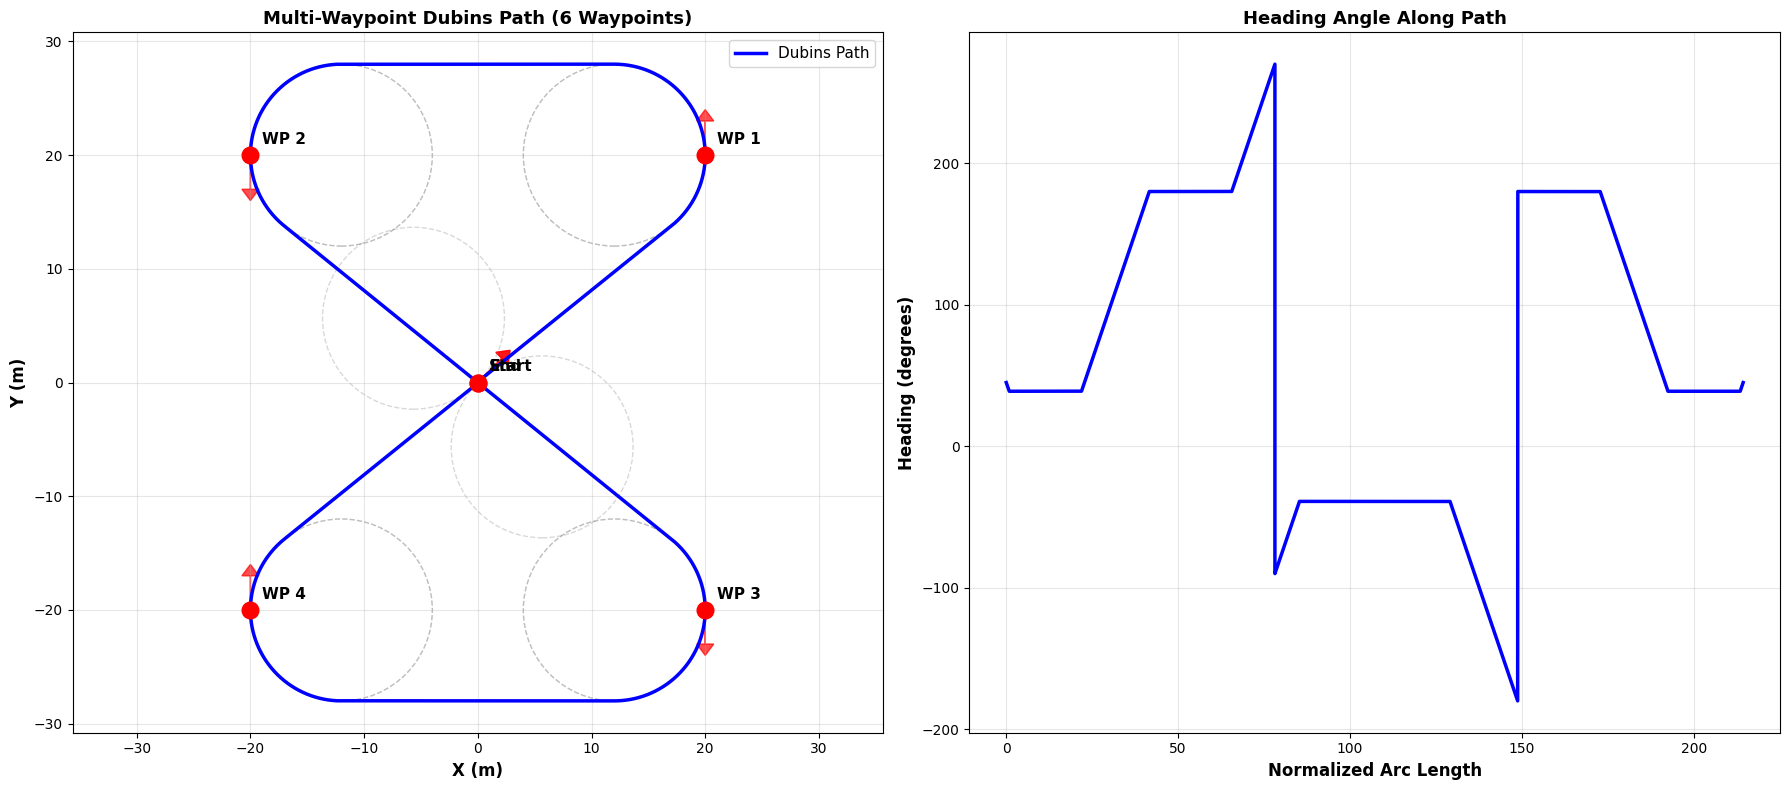


MULTI-WAYPOINT DUBINS PATH SUMMARY
Total path length: 214.4011 m
Number of waypoints: 6
Number of segments: 5
Turn radius: 8 m


In [87]:
# Multi-Waypoint Dubins Path
# Connect 6 waypoints with Dubins trajectories, showing detailed segment breakdown

# Define 6 waypoints: each with position (x, y) and heading (yaw)
waypoints = [
    {'pos': [0, 0], 'yaw': np.pi/4, 'name': 'Start'},
    {'pos': [20, 20], 'yaw': np.pi/2, 'name': 'WP 1'},
    {'pos': [-20, 20], 'yaw': -np.pi/2, 'name': 'WP 2'},
    {'pos': [20, -20], 'yaw': -np.pi/2, 'name': 'WP 3'},
    {'pos': [-20, -20], 'yaw': np.pi/2, 'name': 'WP 4'},
    {'pos': [0, 0], 'yaw': np.pi/4, 'name': 'End'}
]

turn_radius = 8
num_points_per_segment = 2000

# Plan Dubins paths between consecutive waypoints
dubins_paths = []
dubins_plans = []

segment_L = []
segment_direction = []

for i in range(len(waypoints) - 1):
    wp_start = waypoints[i]
    wp_end = waypoints[i + 1]
    
    # Plan Dubins path
    plan = plan_dubins_path(
        wp_start['pos'],
        wp_start['yaw'],
        wp_end['pos'],
        wp_end['yaw'],
        turn_radius
    )
    dubins_plans.append(plan)
    
    # Evaluate path
    path_points = evaluate_dubins_path(
        plan,
        wp_start['pos'],
        wp_start['yaw'],
        wp_end['pos'],
        wp_end['yaw'],
        turn_radius,
        num_points=num_points_per_segment
    )
    dubins_paths.append(path_points)
    
    # Calculate segment lengths from evaluated path
    path_type = plan['type']
    total_seg_length = 0
    for j in range(1, len(path_points)):
        total_seg_length += np.linalg.norm(path_points[j, :2] - path_points[j-1, :2])
    
    # Use the plan's a1, d, a2 values (angles and straight distance)
    # Convert to scalars if they're arrays
    a1 = float(np.atleast_1d(plan['a1'])[0])
    d = float(np.atleast_1d(plan['d'])[0])
    a2 = float(np.atleast_1d(plan['a2'])[0])
    
    # Calculate arc lengths from angles
    L1 = a1 * turn_radius      # Arc 1 length
    L2 = d                     # Straight length
    L3 = a2 * turn_radius      # Arc 2 length

    segment_L.append(L1)
    segment_L.append(L2)
    segment_L.append(L3)
    
    
    a1_deg = float(np.degrees(a1))
    a2_deg = float(np.degrees(a2))

    segment_direction.append('L' if path_type[0] == 'L' else 'R')
    segment_direction.append('S')
    segment_direction.append('L' if path_type[2] == 'L' else 'R')
    
    print(f"\n{'='*70}")
    print(f"Segment {i+1}: {wp_start['name']} → {wp_end['name']}")
    print(f"{'='*70}")
    print(f"Path Type: {path_type}")
    print(f"  Arc 1 (θ={a1_deg:7.2f}°, R={turn_radius:.1f}m):  {L1:8.4f} m")
    print(f"  Straight (distance):         {L2:8.4f} m")
    print(f"  Arc 2 (θ={a2_deg:7.2f}°, R={turn_radius:.1f}m):  {L3:8.4f} m")
    print(f"  {'─'*47}")
    print(f"  Total Length (computed):     {total_seg_length:8.4f} m")
    print(f"  Cost (scaled):               {plan['cost']:8.4f}")

# Combine all segments into one continuous path
full_path = np.vstack(dubins_paths)

# Plot the multi-waypoint path
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Left plot: Path with waypoints
ax1.plot(full_path[:, 0], full_path[:, 1], 'b-', linewidth=2.5, label='Dubins Path')

# Plot waypoints
for i, wp in enumerate(waypoints):
    ax1.plot(wp['pos'][0], wp['pos'][1], 'ro', markersize=12, zorder=5)
    ax1.text(wp['pos'][0] + 1, wp['pos'][1] + 1, wp['name'], fontsize=11, fontweight='bold')
    
    # Draw heading arrows
    arrow_length = 3
    dx = arrow_length * np.cos(wp['yaw'])
    dy = arrow_length * np.sin(wp['yaw'])
    ax1.arrow(wp['pos'][0], wp['pos'][1], dx, dy, 
             head_width=1.5, head_length=1, fc='red', ec='red', alpha=0.7)

# Plot turn circles for each segment
for i, plan in enumerate(dubins_plans):
    circle1 = plt.Circle(plan['c0'], turn_radius, fill=False, linestyle='--', 
                        color='gray', alpha=0.3, linewidth=1)
    circle2 = plt.Circle(plan['c1'], turn_radius, fill=False, linestyle='--', 
                        color='gray', alpha=0.3, linewidth=1)
    ax1.add_patch(circle1)
    ax1.add_patch(circle2)

ax1.set_xlabel('X (m)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Y (m)', fontsize=12, fontweight='bold')
ax1.set_title('Multi-Waypoint Dubins Path (6 Waypoints)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axis('equal')
ax1.legend(fontsize=11, loc='best')

# Right plot: Heading angle vs arc length
arc_lengths = np.zeros(len(full_path))
for i in range(1, len(full_path)):
    arc_lengths[i] = arc_lengths[i-1] + np.linalg.norm(full_path[i, :2] - full_path[i-1, :2])

arc_lengths_norm = arc_lengths #/ arc_lengths[-1]

ax2.plot(arc_lengths_norm, np.degrees(full_path[:, 2]), 'b-', linewidth=2.5)
ax2.set_xlabel('Normalized Arc Length', fontsize=12, fontweight='bold')
ax2.set_ylabel('Heading (degrees)', fontsize=12, fontweight='bold')
ax2.set_title('Heading Angle Along Path', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Mark waypoint transitions
segment_boundaries = []
current_pos = 0
# for i, path in enumerate(dubins_paths[:-1]):
#     current_pos += len(path) #/ len(full_path)
#     ax2.axvline(current_pos, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
#     ax2.text(current_pos, ax2.get_ylim()[1] * 0.95, f'WP {i+1}', 
#             rotation=90, fontsize=10, ha='right', color='red')

plt.tight_layout()
plt.show()

# Print path statistics
print("\n" + "="*70)
print("MULTI-WAYPOINT DUBINS PATH SUMMARY")
print("="*70)
total_length = arc_lengths[-1]
print(f"Total path length: {total_length:.4f} m")
print(f"Number of waypoints: {len(waypoints)}")
print(f"Number of segments: {len(dubins_paths)}")
print(f"Turn radius: {turn_radius} m")
print("="*70)


R S
-0.125
S L
-0.125
L L
0
L S
0.125
S L
-0.125
L L
0
L S
0.125
S R
0.125
R R
0
R S
-0.125
S R
0.125
R R
0
R S
-0.125
S L
-0.125
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      518
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      540

Total number of variables............................:      120
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       80
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr 

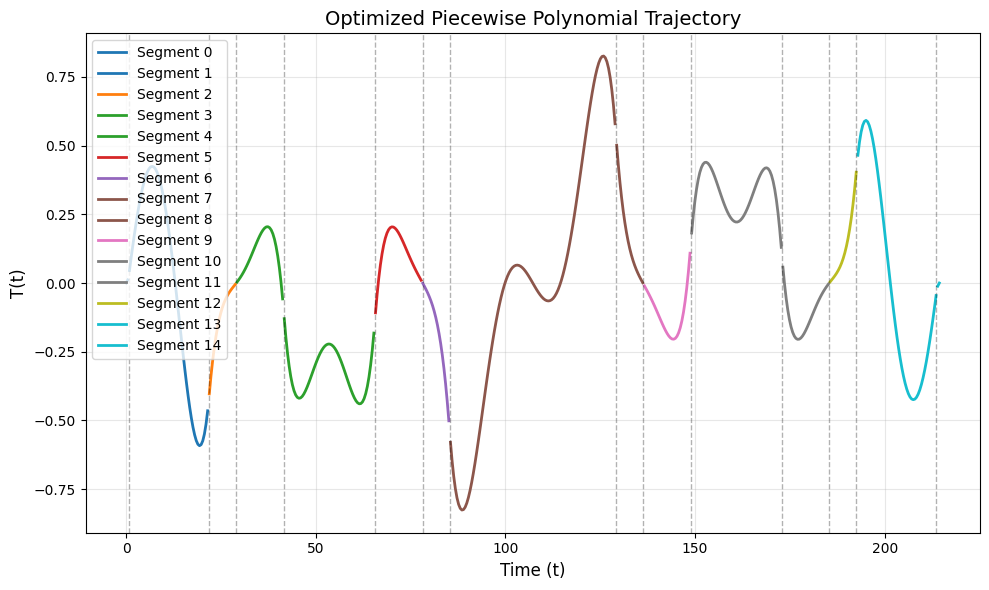

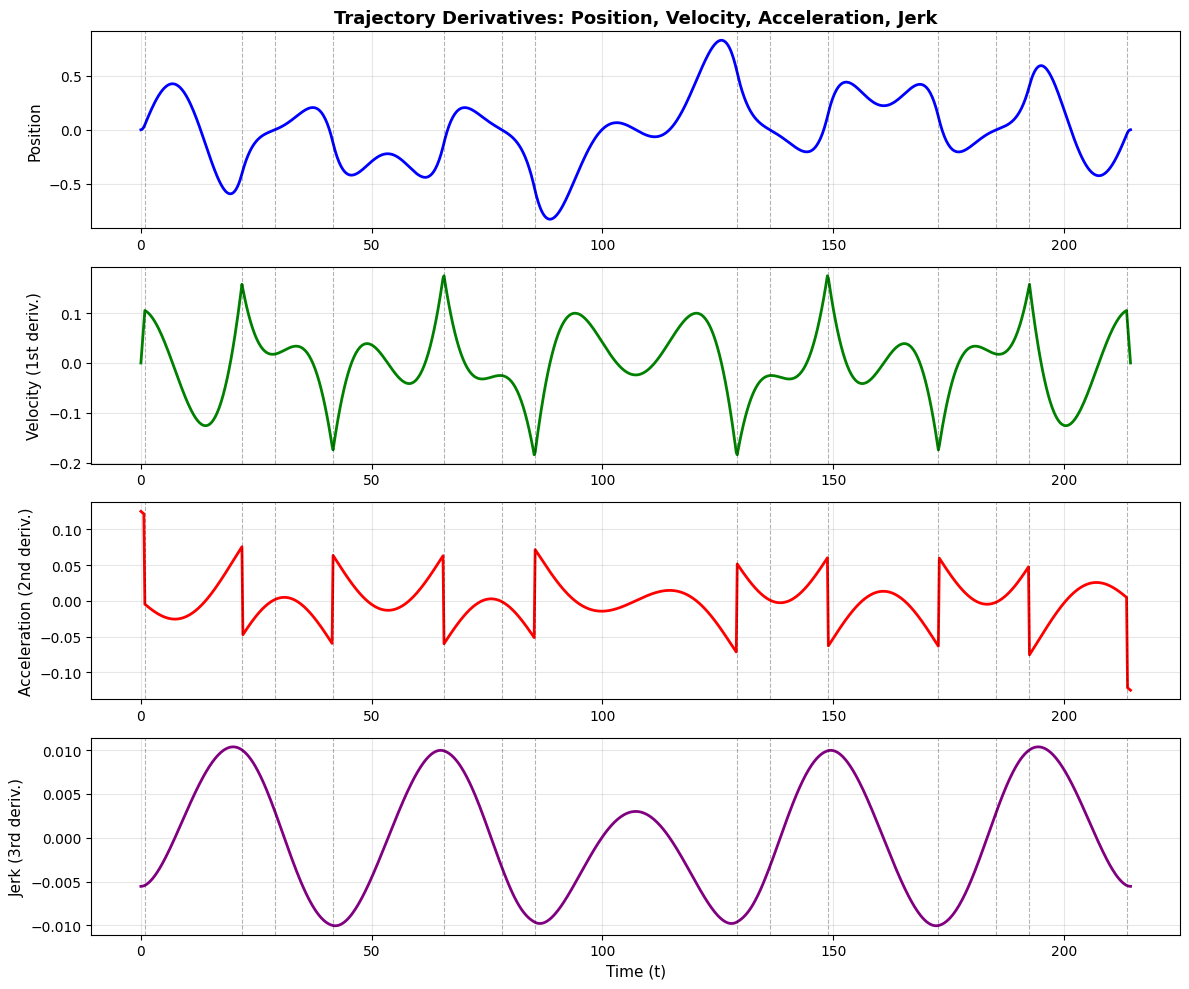

In [88]:
from polynomial_optimization import run_poly_optimization, plot_piecewise_polynomials, plot_derivatives

segments = (len(waypoints)-1) * 3
R = turn_radius#/(42.7781*7.5)  # Turning radius

boundary_positions = [[*([0, None, None]*len(waypoints)),0]]      # Position: start=0, end=
boundary_velocities = [[0, *([None]*(segments-1)), 0]]       # Velocity: start=0, others free

if segment_direction[0] == 'R':
    start_condition = 1/R
elif segment_direction[0] == 'L':
    start_condition = -1/R
else:
    assert -1 > 0 # "PANNIC"

if segment_direction[-1] == 'R':
    end_condition = 1/R
elif segment_direction[-1] == 'L':
    end_condition = -1/R
else:
    assert -1 > 0 # "PANNIC"


boundary_accelerations = [[start_condition, *([None]*(segments-1)), end_condition]]    # Acceleration: start=0

boundary_jerk = [[None]*(segments+1)]             # Jerk: start=0
boundary_snap =  [[None]*(segments+1)]              # Snap: start=0
boundary_crackle = [[None]*(segments+1)]            # Snap: start=0
boundary_pop = [[None]*(segments+1)]             # Snap: start=0
boundary_lock = [[None]*(segments+1)]            # Snap: start=0

boundary_conditions = [
    boundary_positions,
    boundary_velocities,
    boundary_accelerations,
    boundary_jerk,
    boundary_snap,
    boundary_crackle,
    boundary_pop,
    boundary_lock
]

continuity_changes = []
i = 0
for segment in segment_direction[0:-1]:

    current_segment = segment
    next_segment = segment_direction[i+1]

    value = None
    print(current_segment, next_segment)
    match current_segment:
        case 'R':
            if next_segment == 'R':
                value = 0
            elif next_segment == 'L':
                value = -2/R
                boundary_accelerations[0][i] = 0
                boundary_jerk[0][i] = 0
                boundary_velocities[0][i] = 0
            elif next_segment == 'S':
                value = -1/R
        case 'L':
            if next_segment == 'R':
                value = 2/R
                boundary_accelerations[0][i] = 0
                boundary_jerk[0][i] = 0
                boundary_velocities[0][i] = 0
            elif next_segment == 'L':
                value = 0
            elif next_segment == 'S':
                value = 1/R
        case 'S':
            if next_segment == 'R':
                value = 1/R
            elif next_segment == 'L':
                value = -1/R
            elif next_segment == 'S':
                value = 0
        case _:
            assert -1 > 0
    print(value)
    if value != 0:
        continuity_changes.append([2 + i*5, value])  # Default to 0
    i += 1

tau = np.abs(segment_L)  # Segment durations

# Solve optimization problem
outputs = run_poly_optimization(
    order=7,
    tau=tau,
    segments=segments,
    weights=[0.1, 0.1, 0.1, 0.1, 100000, 0.1, 0.1, 0.1],  # Minimize snap (4th derivative)
    boundary_conditions=boundary_conditions,
    continuity=continuity_changes
)

# Plot results
fig1, ax1 = plot_piecewise_polynomials(
    outputs['polys'],
    tau,
    title="Optimized Piecewise Polynomial Trajectory"
)
plt.tight_layout()
plt.show()

fig2, axes2 = plot_derivatives(
    outputs['polys'],
    tau,
    title="Trajectory Derivatives: Position, Velocity, Acceleration, Jerk"
)
plt.show()
# print(tau)
# # Normalize polynomials so input variable ranges from 0 to 1 instead of 0 to tau_i
# # For a polynomial P(t) where t in [0, tau], we w

[0.00000000e+00 1.45246099e-02 2.90492197e-02 ... 2.14372011e+02
 2.14386535e+02 2.14401060e+02]
(10000, 3)


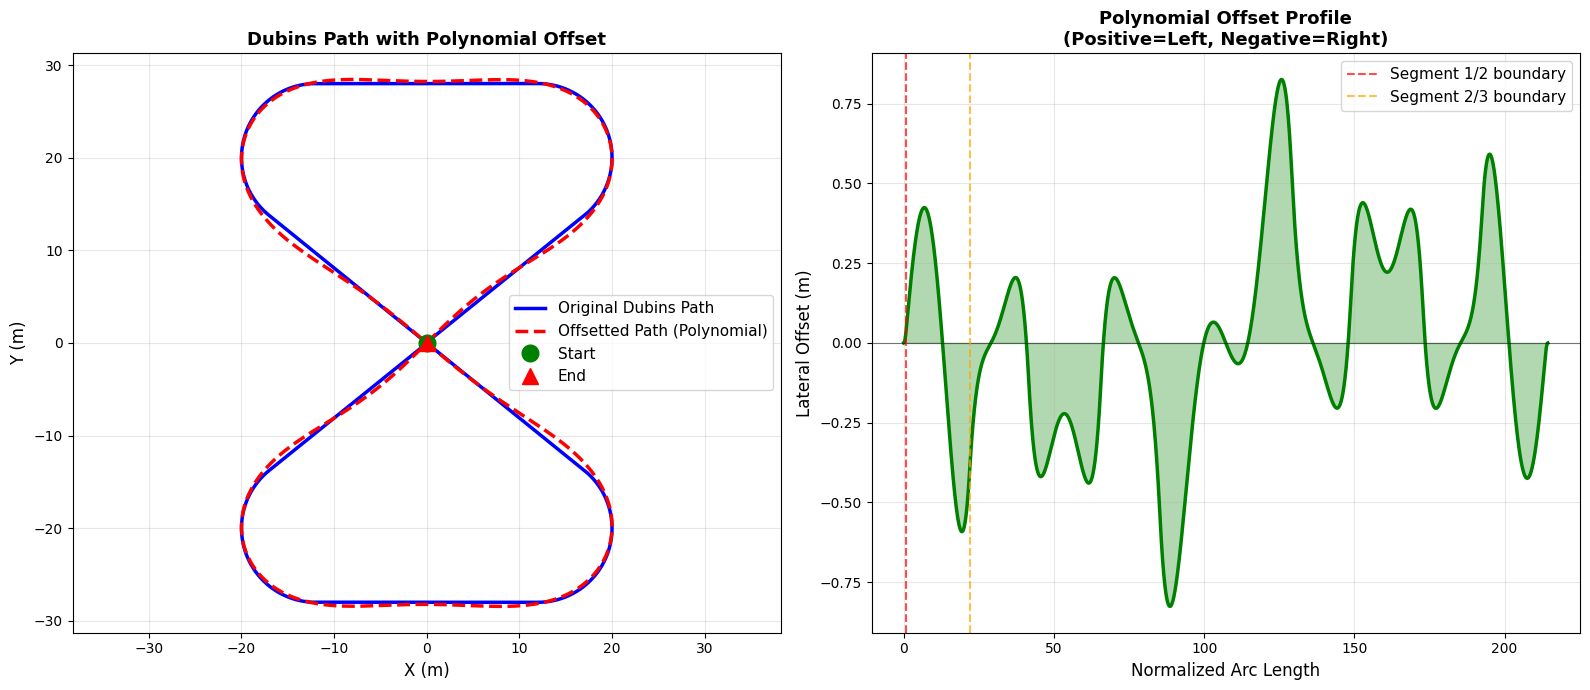


Polynomial Offset Applied to Dubins Path
  Max lateral offset (left): 0.8259 m
  Min lateral offset (right): -0.8259 m
  Offset range: 0.8259 m


In [89]:
offsetted_dubins, arc_lengths, lateral_offsets, seg_boundaries = apply_polynomial_offset_to_dubins(
    full_path, outputs['polys'], tau
)

print(full_path.shape)

seg1_end = seg_boundaries['seg1_end']
seg2_end = seg_boundaries['seg2_end']
total_length = arc_lengths[-1]
arc_lengths_norm = arc_lengths 

# Plot both paths together
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Left plot: Original Dubins vs Offsetted path
ax1.plot(full_path[:, 0], full_path[:, 1], 'b-', linewidth=2.5, label='Original Dubins Path')
ax1.plot(offsetted_dubins[:, 0], offsetted_dubins[:, 1], 'r--', linewidth=2.5, label='Offsetted Path (Polynomial)')

# Mark start and end
ax1.plot(full_path[0,0], full_path[0, 1], 'go', markersize=12, label='Start', zorder=5)
ax1.plot(full_path[-1,0], full_path[-1,1], 'r^', markersize=12, label='End', zorder=5)

ax1.set_xlabel('X (m)', fontsize=12)
ax1.set_ylabel('Y (m)', fontsize=12)
ax1.set_title('Dubins Path with Polynomial Offset', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axis('equal')
ax1.legend(loc='best', fontsize=11)

# Right plot: Lateral offset vs arc length
ax2.plot(arc_lengths_norm, lateral_offsets, 'g-', linewidth=2.5)
ax2.fill_between(arc_lengths_norm, lateral_offsets, alpha=0.3, color='green')
ax2.axhline(0, color='k', linestyle='-', linewidth=0.8, alpha=0.5)

# Mark segment boundaries
ax2.axvline(seg1_end, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Segment 1/2 boundary')
ax2.axvline(seg2_end, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='Segment 2/3 boundary')

ax2.set_xlabel('Normalized Arc Length', fontsize=12)
ax2.set_ylabel('Lateral Offset (m)', fontsize=12)
ax2.set_title('Polynomial Offset Profile\n(Positive=Left, Negative=Right)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best', fontsize=11)

plt.tight_layout()
plt.show()

print("\nPolynomial Offset Applied to Dubins Path")
print(f"  Max lateral offset (left): {np.max(lateral_offsets):.4f} m")
print(f"  Min lateral offset (right): {np.min(lateral_offsets):.4f} m")
print(f"  Offset range: {np.max(np.abs(lateral_offsets)):.4f} m")

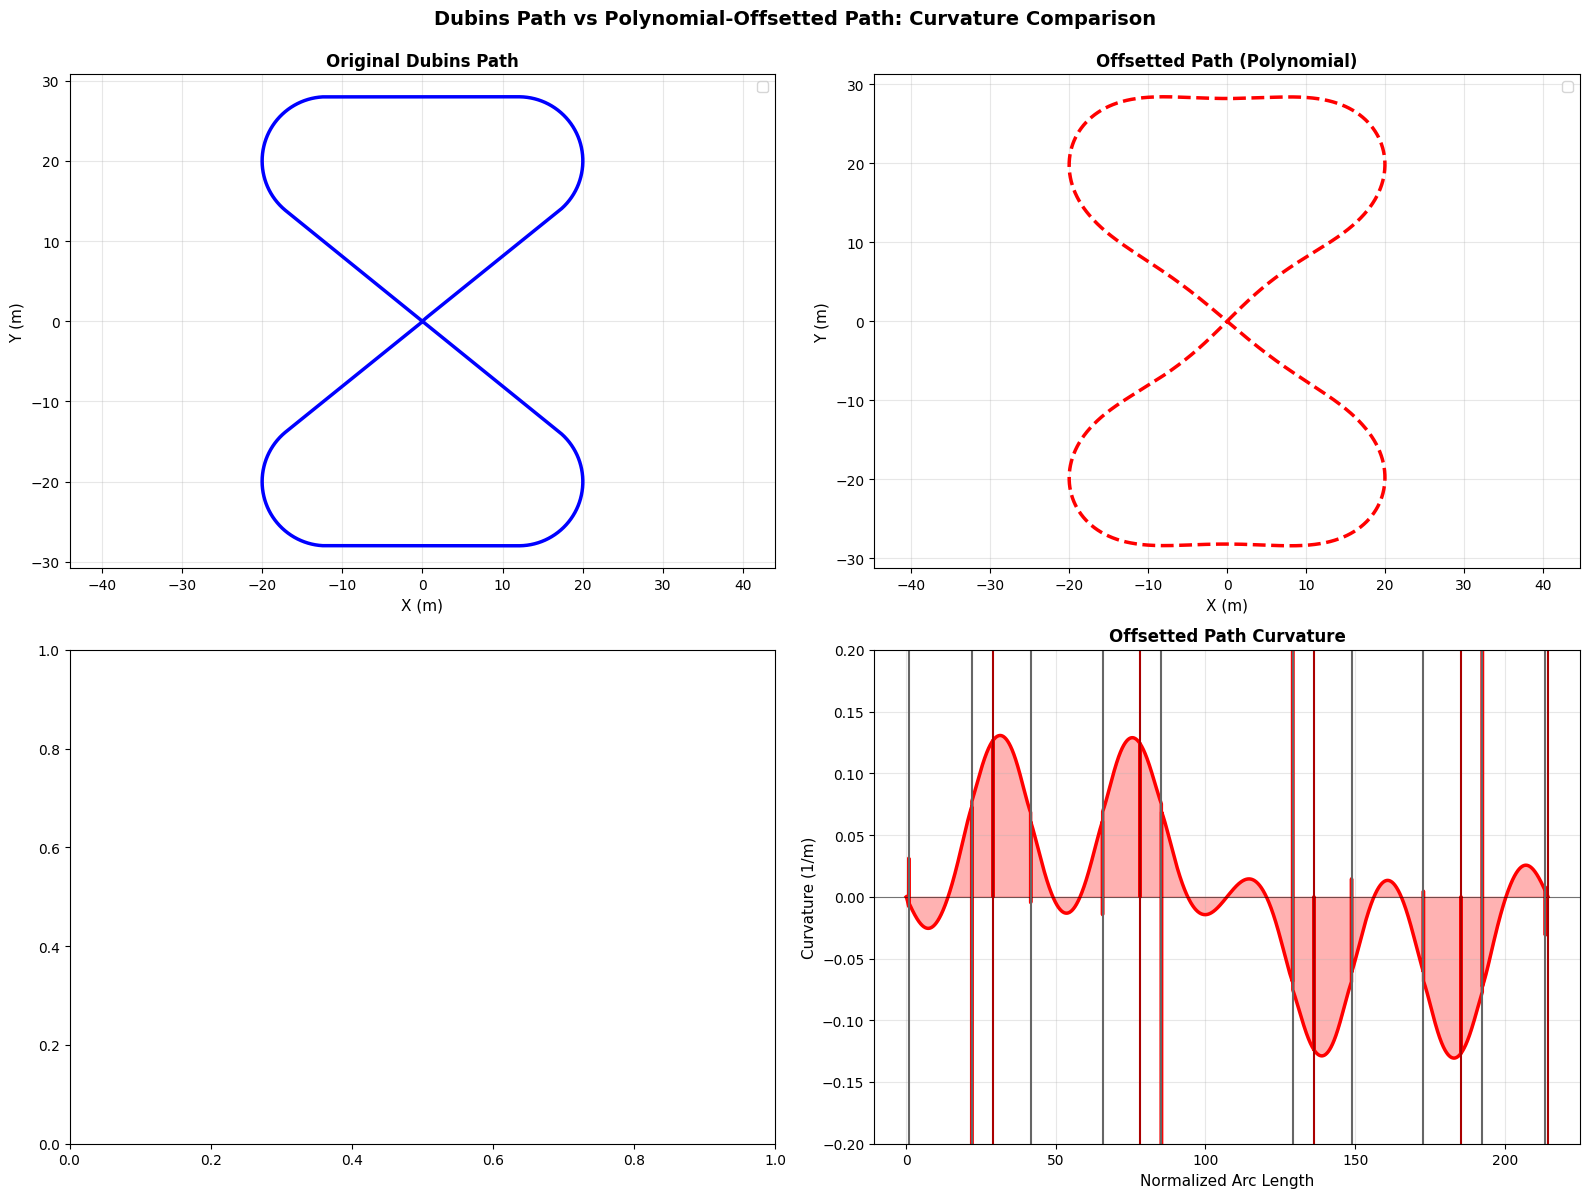


CURVATURE COMPARISON: Original vs Offsetted Path

Original Dubins Path:
  Max curvature:    0.125000 1/m
  Min curvature:    0.000000 1/m
  Mean curvature:   0.091832 1/m
  Min turning radius: 8.0000 m

Offsetted Path (with Polynomial):
  Max curvature:    0.254963 1/m
  Min curvature:    -0.254810 1/m
  Mean curvature:   0.051988 1/m
  Min turning radius: 3.9221 m


In [90]:
# Compute curvature of the offsetted path
offsetted_curvature = compute_curvature_from_xy(offsetted_dubins)


def moving_average(x, window):
    x = np.asarray(x)
    w = window

    # Pad on both sides with edge values (non-destructive)
    padded = np.pad(x, (w//2, w-1-w//2), mode='edge')

    kernel = np.ones(w) / w
    smoothed = np.convolve(padded, kernel, mode='valid')
    return smoothed



# Plot comparison of original vs offsetted curvature
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top left: Original Dubins path
axes[0, 0].plot(full_path[:, 0], full_path[:, 1], 'b-', linewidth=2.5)
# axes[0, 0].plot(start_pos_4[0], start_pos_4[1], 'go', markersize=12, label='Start', zorder=5)
# axes[0, 0].plot(end_pos_4[0], end_pos_4[1], 'r^', markersize=12, label='End', zorder=5)
axes[0, 0].set_xlabel('X (m)', fontsize=11)
axes[0, 0].set_ylabel('Y (m)', fontsize=11)
axes[0, 0].set_title('Original Dubins Path', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axis('equal')
axes[0, 0].legend(fontsize=10)

# Top right: Offsetted path
axes[0, 1].plot(offsetted_dubins[:, 0], offsetted_dubins[:, 1], 'r--', linewidth=2.5)
# axes[0, 1].plot(start_pos_4[0], start_pos_4[1], 'go', markersize=12, label='Start', zorder=5)
# axes[0, 1].plot(end_pos_4[0], end_pos_4[1], 'r^', markersize=12, label='End', zorder=5)
axes[0, 1].set_xlabel('X (m)', fontsize=11)
axes[0, 1].set_ylabel('Y (m)', fontsize=11)
axes[0, 1].set_title('Offsetted Path (Polynomial)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axis('equal')
axes[0, 1].legend(fontsize=10)

# Bottom left: Original curvature
# arc_lengths_original = np.zeros(len(curvature_4))
# for i in range(1, len(curvature_4)):
#     arc_lengths_original[i] = arc_lengths_original[i-1] + np.linalg.norm(points_4[i, :2] - points_4[i-1, :2])
# arc_lengths_original_norm = arc_lengths_original / arc_lengths_original[-1]

# axes[1, 0].plot(arc_lengths_original_norm, curvature_4, 'b-', linewidth=2.5)
# axes[1, 0].fill_between(arc_lengths_original_norm, curvature_4, alpha=0.3, color='blue')
# axes[1, 0].axhline(0, color='k', linestyle='-', linewidth=0.8, alpha=0.5)
# axes[1, 0].set_xlabel('Normalized Arc Length', fontsize=11)
# axes[1, 0].set_ylabel('Curvature (1/m)', fontsize=11)
# axes[1, 0].set_title('Original Path Curvature', fontsize=12, fontweight='bold')
# axes[1, 0].grid(True, alpha=0.3)

# Bottom right: Offsetted curvature
axes[1, 1].plot(arc_lengths_norm, moving_average(offsetted_curvature,1), 'r-', linewidth=2.5)
axes[1, 1].fill_between(arc_lengths_norm, moving_average(offsetted_curvature,1), alpha=0.3, color='red')
axes[1, 1].axhline(0, color='k', linestyle='-', linewidth=0.8, alpha=0.5)
axes[1, 1].set_xlabel('Normalized Arc Length', fontsize=11)
axes[1, 1].set_ylabel('Curvature (1/m)', fontsize=11)
axes[1, 1].set_title('Offsetted Path Curvature', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim((-0.2,0.2))
end_val = 0
for i, tau_val in enumerate(tau):
    if i % 3 == 2:
        color = "#AA0000"
    else:
        color = "#666666"
    axes[1,1].vlines(tau_val+end_val,-2,2, color=color)
    end_val += tau_val

plt.suptitle('Dubins Path vs Polynomial-Offsetted Path: Curvature Comparison', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Print curvature statistics
print("\n" + "="*70)
print("CURVATURE COMPARISON: Original vs Offsetted Path")
print("="*70)
print("\nOriginal Dubins Path:")
print(f"  Max curvature:    {np.max(np.abs(curvature_4)):.6f} 1/m")
print(f"  Min curvature:    {np.min(curvature_4):.6f} 1/m")
print(f"  Mean curvature:   {np.mean(np.abs(curvature_4)):.6f} 1/m")
print(f"  Min turning radius: {1/np.max(np.abs(curvature_4)):.4f} m" if np.max(np.abs(curvature_4)) > 1e-6 else "  (Straight line)")

print("\nOffsetted Path (with Polynomial):")
print(f"  Max curvature:    {np.max(np.abs(offsetted_curvature)):.6f} 1/m")
print(f"  Min curvature:    {np.min(offsetted_curvature):.6f} 1/m")
print(f"  Mean curvature:   {np.mean(np.abs(offsetted_curvature)):.6f} 1/m")
print(f"  Min turning radius: {1/np.max(np.abs(offsetted_curvature)):.4f} m" if np.max(np.abs(offsetted_curvature)) > 1e-6 else "  (Straight line)")

# print(f"\nCurvature Change (RMS): {np.sqrt(np.mean((offsetted_curvature - curvature_4)**2)):.6f} 1/m")
# print("="*70)

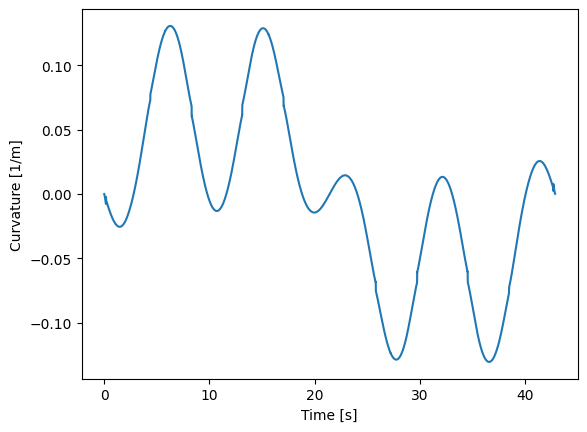

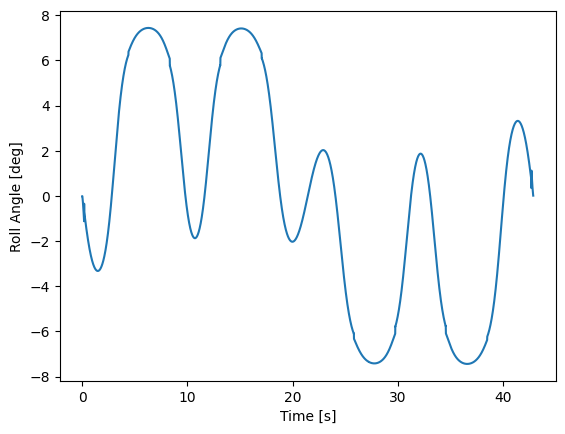

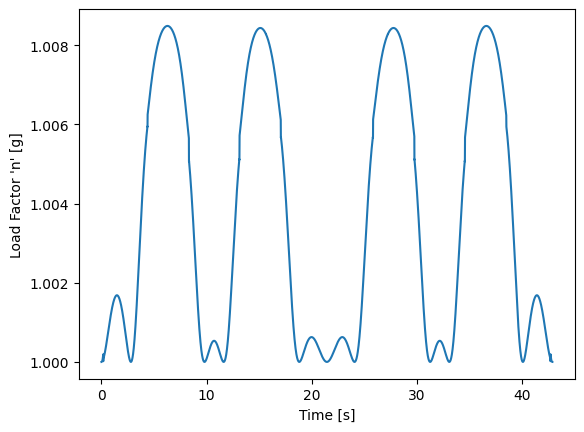

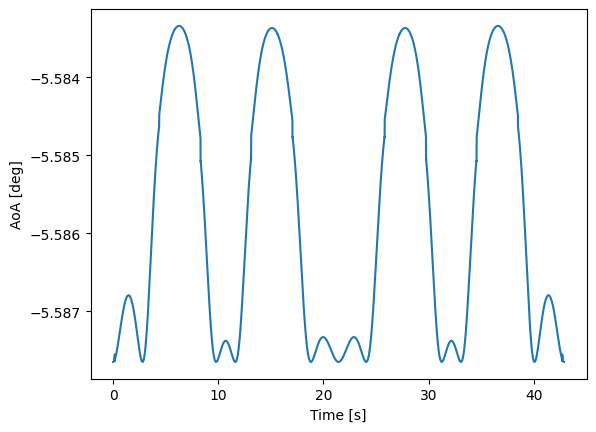

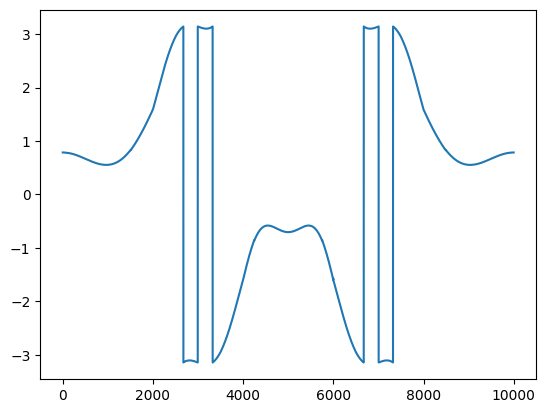

In [ ]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

def hampel_filter(x, window=7, n_sigmas=3):
    x = np.asarray(x, dtype=float)
    if window % 2 == 0:
        raise ValueError("window must be odd")
    k = (window - 1) // 2

    # build sliding windows
    sw = sliding_window_view(x, window)
    med = np.median(sw, axis=1)
    # median absolute deviation
    mad = np.median(np.abs(sw - med[:, None]), axis=1)
    # avoid zero mad
    mad[mad == 0] = 1e-12
    threshold = n_sigmas * 1.4826 * mad  # 1.4826 scales MAD -> std

    # pad med/threshold to full length
    med_full = np.pad(med, (k, k), mode='edge')
    threshold_full = np.pad(threshold, (k, k), mode='edge')

    diff = np.abs(x - med_full)
    outliers = diff > threshold_full
    x_clean = x.copy()
    x_clean[outliers] = med_full[outliers]
    return x_clean

plt.plot(hampel_filter(offsetted_curvature, n_sigmas=2))


def rolling_median_replace(x, window=7, thresh=3.0, replace_with='median'):
    x = np.asarray(x, dtype=float)
    if window % 2 == 0:
        raise ValueError("window must be odd")
    k = (window - 1) // 2
    sw = sliding_window_view(x, window)
    med = np.median(sw, axis=1)
    med_full = np.pad(med, (k, k), mode='edge')

    residual = np.abs(x - med_full)
    sigma_est = np.median(np.abs(x - np.median(x))) * 1.4826
    if sigma_est == 0:
        sigma_est = np.std(x) + 1e-12
    outliers = residual > (thresh * sigma_est)

    x_clean = x.copy()
    if replace_with == 'median':
        x_clean[outliers] = med_full[outliers]
    else:  # interpolate across outliers
        good = ~outliers
        x_clean[outliers] = np.interp(np.flatnonzero(outliers),
                                      np.flatnonzero(good),
                                      x[good])
    return x_clean


v_trim = 5 #m/s
g = 9.81
Cl_alpha = 4.7
Cl_0 = 0.5
W = 0.065 * g
rho = 1.225

ff_kappa = rolling_median_replace(offsetted_curvature, thresh=0.1)
 
ff_phi = np.atan(v_trim**2 * ff_kappa) /g 

ff_n = 1/np.cos(ff_phi) 
ff_alpha = (2 * ff_n * W / rho / (v_trim **2) - Cl_0)/Cl_alpha

plt.clf()
# Arc length needs updated to be the new lengths
plt.plot(arc_lengths_norm/v_trim,  ff_kappa)
plt.xlabel("Time [s]")
plt.ylabel("Curvature [1/m]")
plt.show()
plt.plot(arc_lengths_norm/v_trim,  np.rad2deg(ff_phi))
plt.xlabel("Time [s]")
plt.ylabel("Roll Angle [deg]")
plt.show()
plt.plot(arc_lengths_norm/v_trim,  ff_n)
plt.xlabel("Time [s]")
plt.ylabel("Load Factor 'n' [g]")
plt.show()
plt.plot(arc_lengths_norm/v_trim,  np.rad2deg(ff_alpha))
plt.xlabel("Time [s]")
plt.ylabel("AoA [deg]")
plt.show()


import numpy as np

pts = offsetted_dubins  # shape (N, 2)

dx = np.diff(pts[:, 0])
dy = np.diff(pts[:, 1])


dx = np.append(dx, dx[-1])
dy = np.append(dy, dy[-1])
# add(dx[-1])
# dy.append(dx[-1])

heading = np.arctan2(dy, dx)      # length N-1

print(heading.shape)
plt.plot(rolling_median_replace(heading, thresh=0.1))



In [92]:
A

NameError: name 'A' is not defined